# **Importing Libraries:**

In [ ]:
!pip install nltk

In [ ]:
 # Importing required libraries...

from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
pd.set_option('display.max_rows', None)
%matplotlib inline


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


# **List of disease URLs:**

In [ ]:
# List of URLs to scrap data

BASE_URL = [
            "http://www.druglib.com/drugindex/category/idx-drugcateg_antineoplastics-cancer-treatments.html",
            "http://www.druglib.com/drugindex/category/idx-drugcateg_analgesics-pain-relievers.html",
            "http://www.druglib.com/drugindex/category/idx-drugcateg_cardiovascular-agents.html",
            "http://www.druglib.com/drugindex/category/idx-drugcateg_antidepressants.html",
            "http://www.druglib.com/drugindex/category/idx-drugcateg_gastrointestinal-agents.html"
]


# **HTML Parser:**

In [ ]:
# HTML Parser Function
def html_parser(url):
    response = requests.get(url)
    htmlcontent = response.content
    soup = BeautifulSoup(htmlcontent,"html.parser")
    value = soup.get_text()
    return value

In [ ]:
# antineoplastics_cancer html parse
def drugcateg_antineoplastics_cancer():
    value = html_parser(BASE_URL[0])
    value = value.split("\n")
    start_name = "8-MOP"
    end_name = "Zykadia"
    start_id = value.index(start_name)
    end_id = value.index(end_name)
    value = value[start_id:end_id + 1]
    value = [i.lower().replace(" ", "-") for i in value]
    return value

# drugcateg_analgesics_pain_reliever html parse
def drugcateg_analgesics_pain_reliever():
    value = html_parser(BASE_URL[1])
    value = value.split("\n")
    start_name = "Acetaminophen"
    end_name = "Zydone"
    start_id = value.index(start_name)
    end_id = value.index(end_name)
    value = value[start_id:end_id + 1]
    value = [i.lower().replace(" ", "-") for i in value]
    return value

# drugcateg_cardiovascular_agents html parse
def drugcateg_cardiovascular_agents():
    value = html_parser(BASE_URL[2])
    value = value.split("\n")
    start_name = "Abbokinase"
    end_name = "Zosyn"
    start_id = value.index(start_name)
    end_id = value.index(end_name)
    value = value[start_id:end_id + 1]
    value = [i.lower().replace(" ", "-") for i in value]
    return value

# drugcateg_antidepressants html parse
def drugcateg_antidepressants():
    value = html_parser(BASE_URL[3])
    value = value.split("\n")
    start_name = "Aplenzin"
    end_name = "Zyban"
    start_id = value.index(start_name)
    end_id = value.index(end_name)
    value = value[start_id:end_id + 1]
    value = [i.lower().replace(" ", "-") for i in value]
    return value


## **Creating urls to collect drug's reviews data:**

In [ ]:
# make urls for every drug reviews data
def make_url(drug_list):
    base_rating_url= "http://www.druglib.com/ratingsreviews/"
    url_list = []
    for i in drug_list:
        url_list.append(base_rating_url + i + "/")
    return url_list


# **Parsing drug's reviews data:**

In [ ]:
# parse review data of drugs from url
def get_review(link_list, disease_name):
    drug_details = {"drug name": [], "Disease Name": [], "Review_Count": [],  "Overall_Ratings": [], "star ratings": [], "Effectiveness_Score": [],
                    "Side_Effect_Score": [],
                    "overall rating": [], "effectiveness": [], "side effects": [], "condition / reason": [],
                    "dosage & duration": [], "other conditions": [], "other drugs taken": [], "benefits": [], "comments": []}
    for i in link_list:
        try:
            # extracting html data
            response = requests.get(i)
            htmlcontent = response.content
            soup = BeautifulSoup(htmlcontent, "html.parser")

            # extracting drug name and description
            drug_description = soup.find('div', {'class': 'info_box'}).get_text()
            drug_name = i.split("/")[-2].capitalize()

            # extracting reviews and ratings
            value = drug_description.split(". ")
            review_and_rating = value[1].split(",")
            reviews = "".join(re.findall(r'[-+]?[.]?[\d]+', review_and_rating[0]))
            ratings = "".join(re.findall(r'[-+]?[.]?[\d]+', review_and_rating[1]))

            # extracting effective_score and side_effect_score
            effective_score_and_side_effect = value[2].split(" and ")
            effective_score = "".join(re.findall(r'[-+]?[.]?[\d]+', effective_score_and_side_effect[0]))
            side_effect_score = "".join(re.findall(r'[-+]?[.]?[\d]+', effective_score_and_side_effect[1]))

            # extracting text reviews data
            heading = soup.find_all('td', class_= "review2")
            heading_data = soup.find_all('td', class_= "review3")

            # extracting review wise star ratings
            overall_ratings = soup.findAll('img')

            overall_ratings_list = []
            for i in overall_ratings:
              img_rating = i.get("src").lower()
              if img_rating in ["/img/red_star.gif", "/img/grey_star.gif"]:
                overall_ratings_list.append(img_rating)

            ratings_list = []
            rating, count = 0, 0
            for val in overall_ratings_list:
              count += 1
              if val == "/img/red_star.gif" and count <= 10:
                rating += 1
              if count == 10:
                ratings_list.append(rating)
                rating, count = 0, 0
            drug_details["star ratings"].append(ratings_list)

            # fetching headings and heading_values
            all_headings = []
            for j in heading:
              all_headings.append(j.get_text().lower().strip().split(":")[0])
            all_heading_data = []
            for j in heading_data:
              all_heading_data.append(j.get_text().lower().strip())

            zipped_data = list(zip(all_headings, all_heading_data))

            all_reviews = {}
            for j in zipped_data:
              if j[0] in all_reviews:
                all_reviews[j[0]].append(j[1])
              else:
                all_reviews[j[0]] = [j[1]]

            for k, v in all_reviews.items():
              drug_details[k].append(v)

            # appendig data to drug_details dict
            drug_details["drug name"].append([drug_name]*len(ratings_list))
            drug_details["Overall_Ratings"].append([ratings]*len(ratings_list))
            drug_details["Review_Count"].append([int(reviews)]*len(ratings_list))
            drug_details["Effectiveness_Score"].append([effective_score]*len(ratings_list))
            drug_details["Side_Effect_Score"].append([side_effect_score]*len(ratings_list))
            drug_details["Disease Name"].append([disease_name]*len(ratings_list))
        except:
            continue
    # sorting side_effects data
    side_effect_list = []
    for i in drug_details['side effects']:
      side_effect_list.append([val for idx, val in enumerate(i) if idx%2== 0])
    drug_details['side effects'] = side_effect_list

    # removing blank column
    del drug_details['overall rating']

    # flatten drug_details
    for k, v in drug_details.items():
      drug_details[k] = sum(v, [])

    return drug_details


# **Collect Dataset using Web Scraping:**

In [ ]:
# parsing html data:
drugcateg_antineoplastics_cancer = drugcateg_antineoplastics_cancer()
drugcateg_analgesics_pain_reliever = drugcateg_analgesics_pain_reliever()
drugcateg_cardiovascular_agents = drugcateg_cardiovascular_agents()
drugcateg_antidepressants = drugcateg_antidepressants()

In [ ]:
# making urls for drugs:
drugcateg_antineoplastics_cancer = make_url(drugcateg_antineoplastics_cancer)
drugcateg_analgesics_pain_reliever = make_url(drugcateg_analgesics_pain_reliever)
drugcateg_cardiovascular_agents = make_url(drugcateg_cardiovascular_agents)
drugcateg_antidepressants = make_url(drugcateg_antidepressants)

In [ ]:
# creating datasets for each disease:
dataset_cancer = get_review(drugcateg_antineoplastics_cancer, "Antineoplastics (Cancer)")
dataset_analgesics_pain_reliever = get_review(drugcateg_analgesics_pain_reliever, "Analgesics")
dataset_cardiovascular_agents = get_review(drugcateg_cardiovascular_agents, "Cardiovascular Agents")
dataset_antidepressants = get_review(drugcateg_antidepressants, "Antidepressants")

# **Cancer DataFrame:**

In [ ]:
# Creating Dataframe for cancer disease:

cancer_df = pd.DataFrame(dataset_cancer)
print(cancer_df.shape)
cancer_df.head(5)


(258, 15)


drug name  ...                                           comments
0    Aldara  ...  i used 1/4 of a packet(5% cream) on just my no...
1    Aldara  ...  to put aldara on the surgical wounds 3 x per w...
2    Aldara  ...  put the cream on the new surgical scar immedia...
3    Aldara  ...  the cream is applied at bedtime for five night...
4    Aldara  ...  the treatment involved a 6 week period of appl...

[5 rows x 15 columns]

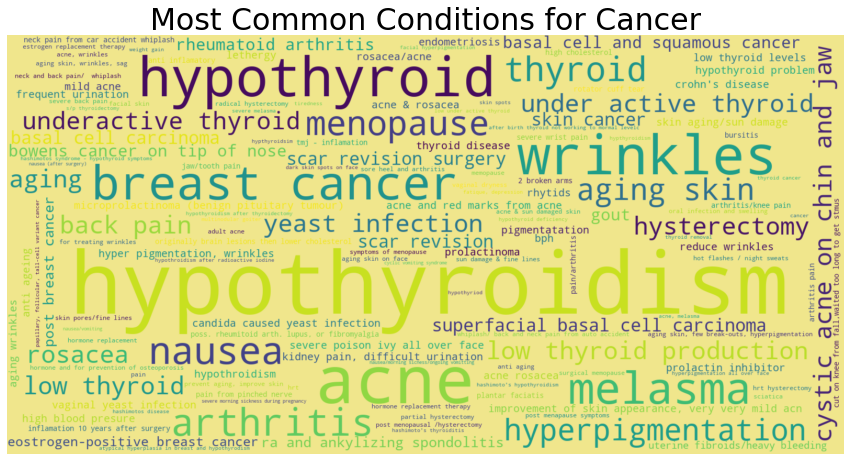

In [ ]:
Bigram_Freq = nltk.FreqDist(cancer_df['condition / reason'])
bigram_wordcloud = WordCloud(background_color = 'khaki', max_words = 500 , width = 1600 , height = 800).generate_from_frequencies(Bigram_Freq)
plt.figure(figsize = (15,10))
plt.imshow(bigram_wordcloud,interpolation = 'bilinear')
plt.title('Most Common Conditions for Cancer', fontsize = 30)
plt.axis("off")
plt.show()

# **Analgesics DataFrame:**

In [ ]:
# Creating Dataframe for analgesics disease:

analgesics_df = pd.DataFrame(dataset_analgesics_pain_reliever)
print(analgesics_df.shape)
analgesics_df.head(5)


(489, 15)


drug name  ...                                           comments
0     Actiq  ...  actiq should only be taken by individuals who ...
1  Cataflam  ...  i took this medication for 7 days for lower ba...
2  Catapres  ...  i wanted to stop hot flashes without going on ...
3  Catapres  ...  i take one tablet at bedtime.  i try to delay ...
4  Catapres  ...  i'm not sure what this question means, and may...

[5 rows x 15 columns]

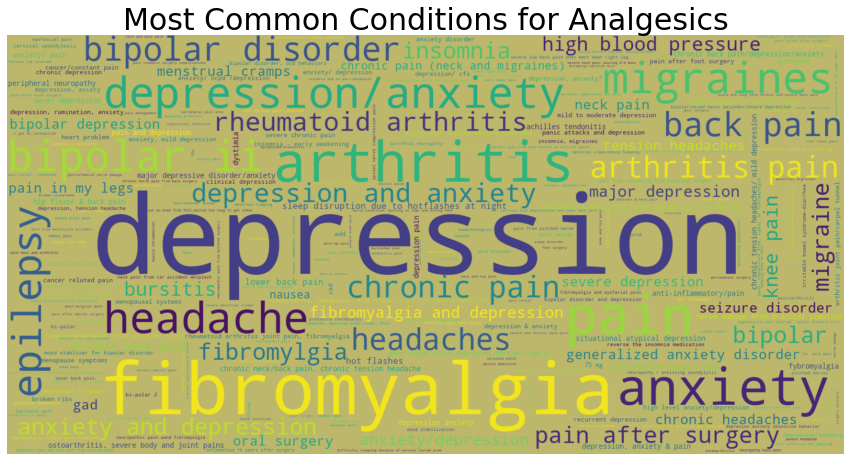

In [ ]:
Bigram_Freq = nltk.FreqDist(analgesics_df['condition / reason'])
bigram_wordcloud = WordCloud(background_color = 'darkkhaki', max_words = 500 , width = 1600 , height = 800).generate_from_frequencies(Bigram_Freq)
plt.figure(figsize = (15,10))
plt.imshow(bigram_wordcloud,interpolation = 'bilinear')
plt.title('Most Common Conditions for Analgesics', fontsize = 30)
plt.axis("off")
plt.show()

# **Cardiovascular DataFrame:**

In [ ]:
# Creating Dataframe for cardiovascular disease:

cardiovascular_df = pd.DataFrame(dataset_cardiovascular_agents)
print(cardiovascular_df.shape)
cardiovascular_df.head(5)


(240, 15)


drug name  ...                                           comments
0   Accupril  ...  taken once daily in combination with hyzaar. m...
1  Aldactone  ...  interestingly, if i took four 250mg doses per ...
2  Aldactone  ...  i am happy to complete this but dont know what...
3  Aldactone  ...  sprioloctone has been prescibed to help with h...
4  Aldactone  ...  i started taking spironolactone for hormonal a...

[5 rows x 15 columns]

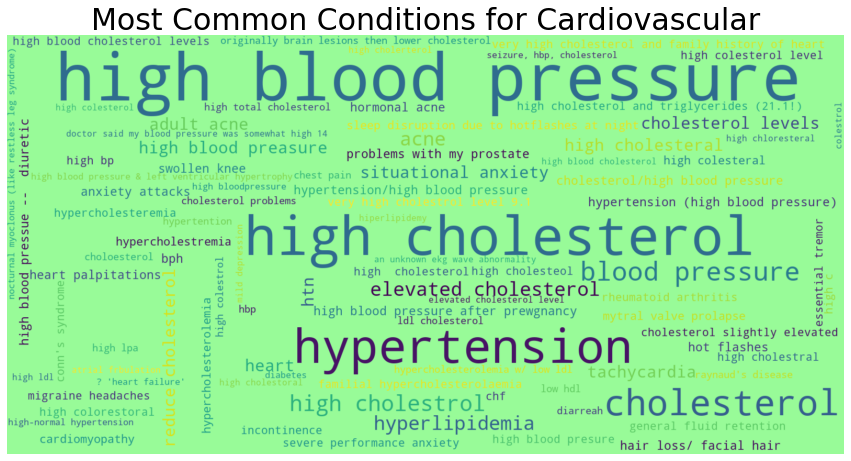

In [ ]:
Bigram_Freq = nltk.FreqDist(cardiovascular_df['condition / reason'])
bigram_wordcloud = WordCloud(background_color = 'palegreen', max_words = 500 , width = 1600 , height = 800).generate_from_frequencies(Bigram_Freq)
plt.figure(figsize = (15,10))
plt.imshow(bigram_wordcloud,interpolation = 'bilinear')
plt.title('Most Common Conditions for Cardiovascular', fontsize = 30)
plt.axis("off")
plt.show()

# **Depressants DataFrame:**:

In [ ]:
# Creating Dataframe for depressants disease:

depressants_df = pd.DataFrame(dataset_antidepressants)
print(depressants_df.shape)
depressants_df.head(5)


(547, 15)


drug name  ...                                           comments
0    Celexa  ...  i took 20/mg a day each day for some number of...
1    Celexa  ...  not sure what you mean by this. was in relatio...
2    Celexa  ...  i took the medicine 20 mg once a day for one y...
3    Celexa  ...  treated 2 years by a psychologist who prescrib...
4    Celexa  ...  i take 1 1/2 40 mg. tablets of celexa once a day.

[5 rows x 15 columns]

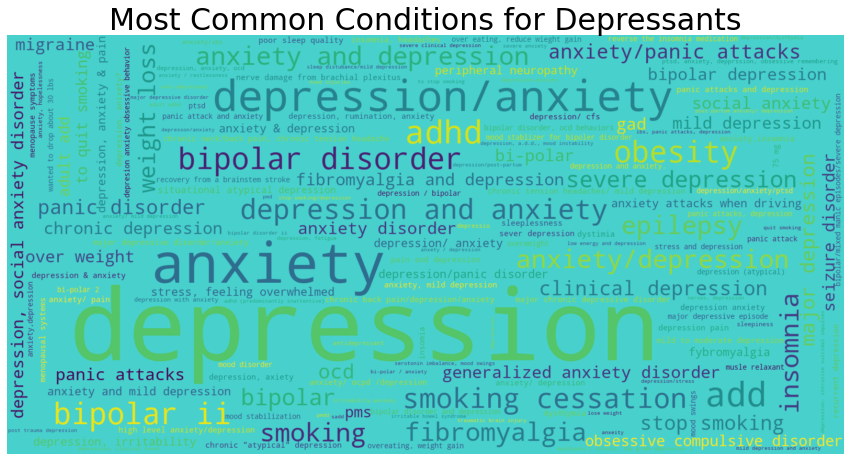

In [ ]:
Bigram_Freq = nltk.FreqDist(depressants_df['condition / reason'])
bigram_wordcloud = WordCloud(background_color = 'mediumturquoise', max_words = 500 , width = 1600 , height = 800).generate_from_frequencies(Bigram_Freq)
plt.figure(figsize = (15,10))
plt.imshow(bigram_wordcloud,interpolation = 'bilinear')
plt.title('Most Common Conditions for Depressants', fontsize = 30)
plt.axis("off")
plt.show()

# **Merged Dataframe:**

In [ ]:
# merging all disease dataframes...

merged_df = pd.concat([cancer_df, analgesics_df,
                       cardiovascular_df, depressants_df])
print(merged_df.shape)
merged_df.head(5)

(1534, 15)


drug name  ...                                           comments
0    Aldara  ...  i used 1/4 of a packet(5% cream) on just my no...
1    Aldara  ...  to put aldara on the surgical wounds 3 x per w...
2    Aldara  ...  put the cream on the new surgical scar immedia...
3    Aldara  ...  the cream is applied at bedtime for five night...
4    Aldara  ...  the treatment involved a 6 week period of appl...

[5 rows x 15 columns]

# **Data Preprocessing:**

In [ ]:
merged_df.columns

Index(['drug name', 'Disease Name', 'Review_Count', 'Overall_Ratings',
       'star ratings', 'Effectiveness_Score', 'Side_Effect_Score',
       'effectiveness', 'side effects', 'condition / reason',
       'dosage & duration', 'other conditions', 'other drugs taken',
       'benefits', 'comments'],
      dtype='object')

In [ ]:
merged_df.rename(columns={'drug name': 'Drug_Name', 'Disease Name': 'Disease_Name', 'Overall_Ratings': 'Rating_Avg',
                           'star ratings': 'Rating', 'effectiveness': 'Effectiveness', 'side effects': 'Side_Effects',
                           'condition / reason': 'Condition', 'dosage & duration':'Dosage_Duration', 'other conditions': 'Other_Condition',
                           'other drugs taken': 'Other_Drug_Taken', 'benefits': 'Benefits', 'comments': 'Reviews'}, inplace=True)

In [ ]:
merged_df.isnull().sum()

Drug_Name              0
Disease_Name           0
Review_Count           0
Rating_Avg             0
Rating                 0
Effectiveness_Score    0
Side_Effect_Score      0
Effectiveness          0
Side_Effects           0
Condition              0
Dosage_Duration        0
Other_Condition        0
Other_Drug_Taken       0
Benefits               0
Reviews                0
dtype: int64

Findings: Dataframe has no missing (null) values.

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 196
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Drug_Name            2324 non-null   object
 1   Disease_Name         2324 non-null   object
 2   Review_Count         2324 non-null   int64 
 3   Rating_Avg           2324 non-null   object
 4   Rating               2324 non-null   int64 
 5   Effectiveness_Score  2324 non-null   object
 6   Side_Effect_Score    2324 non-null   object
 7   Effectiveness        2324 non-null   object
 8   Side_Effects         2324 non-null   object
 9   Condition            2324 non-null   object
 10  Dosage_Duration      2324 non-null   object
 11  Other_Condition      2324 non-null   object
 12  Other_Drug_Taken     2324 non-null   object
 13  Benefits             2324 non-null   object
 14  Reviews              2324 non-null   object
dtypes: int64(2), object(13)
memory usage: 290.5+ KB


In [ ]:
# changing data types
merged_df["Rating_Avg"] = merged_df["Rating_Avg"].astype(float).round().astype(int)
merged_df["Effectiveness_Score"] = merged_df["Effectiveness_Score"].astype(float).round().astype(int)
merged_df["Side_Effect_Score"] = merged_df["Side_Effect_Score"].astype(float).round().astype(int)

In [ ]:
merged_df.describe()

Review_Count   Rating_Avg       Rating  Effectiveness_Score  \
count   2324.000000  2324.000000  2324.000000          2324.000000   
mean      24.814974     7.026678     6.995697             7.775387   
std       16.821983     1.228928     2.926121             0.992601   
min        1.000000     1.000000     1.000000             2.000000   
25%       10.000000     6.000000     5.000000             7.000000   
50%       22.000000     7.000000     8.000000             8.000000   
75%       40.000000     8.000000     9.000000             8.000000   
max       58.000000    10.000000    10.000000            10.000000   

       Side_Effect_Score  
count        2324.000000  
mean            7.466867  
std             1.120476  
min             2.000000  
25%             7.000000  
50%             7.000000  
75%             8.000000  
max            10.000000

In [ ]:
merged_df['Drug_Name'].value_counts()[0:20]

Effexor          92
Effexor-xr       92
Cymbalta         84
Lamictal         80
Celebrex         72
Prinivil         60
Paxil            58
Synthroid        53
Mobic            52
Zoloft           52
Prozac           51
Motrin           45
Wellbutrin       42
Lipitor          42
Zomig            40
Differin         38
Neurontin        38
Nexium           37
Wellbutrin-xl    35
Meridia          34
Name: Drug_Name, dtype: int64

In [ ]:
merged_df['Disease_Name'].value_counts()

Antidepressants             547
Analgesics                  489
Antineoplastics (Cancer)    258
Cardiovascular Agents       240
Gastrointestinal Agents     197
Anti-Inflammatory Agents    195
Antihypertensive Agents     123
Antirheumatic Agents        116
Migraine                     76
Obesity (Weight Control)     60
Diabetes                     23
Name: Disease_Name, dtype: int64

In [ ]:
merged_df['Rating_Avg'].value_counts()

8     711
7     698
6     578
5     129
9     121
10     43
4      20
2      10
1       9
3       5
Name: Rating_Avg, dtype: int64

In [ ]:
merged_df['Rating'].value_counts()

10    551
8     439
9     335
7     280
1     222
5     118
3     115
6     107
2      83
4      74
Name: Rating, dtype: int64

In [ ]:
merged_df['Review_Count'].value_counts()[0:20]

46    184
42    168
30    120
18    108
3      93
1      90
40     80
4      76
38     76
15     75
2      70
23     69
58     58
14     56
8      56
11     55
6      54
53     53
52     52
26     52
Name: Review_Count, dtype: int64

In [ ]:
merged_df['Effectiveness_Score'].value_counts()

8     1189
7      636
9      258
10     106
6       86
5       28
4       11
2        6
3        4
Name: Effectiveness_Score, dtype: int64

In [ ]:
merged_df['Side_Effect_Score'].value_counts()

8     793
7     750
6     351
9     287
10     77
5      44
4      18
2       4
Name: Side_Effect_Score, dtype: int64

In [ ]:
merged_df['Effectiveness'].value_counts()

highly effective          916
considerably effective    717
moderately effective      351
ineffective               173
marginally effective      167
Name: Effectiveness, dtype: int64

In [ ]:
merged_df['Side_Effects'].value_counts()

mild side effects                775
no side effects                  711
moderate side effects            456
severe side effects              237
extremely severe side effects    145
Name: Side_Effects, dtype: int64

In [ ]:
merged_df['Condition'].value_counts()[0:20]

depression              304
high blood pressure     104
migraine                 59
hypertension             51
acne                     48
arthritis                39
anxiety                  38
acid reflux              36
migraines                35
high cholesterol         35
hypothyroidism           32
fibromyalgia             27
gerd                     24
rheumatoid arthritis     23
depression/anxiety       22
weight loss              22
obesity                  20
pain                     20
migraine headaches       18
nausea                   15
Name: Condition, dtype: int64

In [ ]:
merged_df['Dosage_Duration'].value_counts()[0:10]

300 mg initially increased to 450 mg/day  taken 1 time daily for the period of 6 years at 300 mg, 1 year at 450 mg    5
750mg  taken twice a day for the period of one week                                                                   4
200 mg  taken 1x/day for the period of 1 month                                                                        4
10mg  taken once daily for the period of 3 months                                                                     4
200 mg  taken once per day for the period of 3 years                                                                  4
750 mg  taken 2 x per day for the period of 30 days                                                                   4
200 mg  taken 1 a day for the period of 2 years                                                                       4
200 mlg  (dosage frequency: 2x day)  for the period of 2 months                                                       4
200 mg  taken daily for the period of st

In [ ]:
merged_df['Other_Condition'].value_counts()[0:15]

none                   998
n/a                     85
anxiety                 61
high blood pressure     37
asthma                  28
hypothyroidism          24
depression              23
high cholesterol        19
hypertension            18
hypothyroid             15
na                      12
depression, anxiety     11
migraines               11
allergies               11
adhd                     9
Name: Other_Condition, dtype: int64

In [ ]:
merged_df['Other_Drug_Taken'].value_counts()[0:15]

none             950
n/a               57
synthroid         24
birth control     16
klonopin          10
nothing           10
vitamins           9
prilosec           9
trazadone          8
xanax              8
na                 8
lexapro            8
nil                7
wellbutrin         7
cymbalta           7
Name: Other_Drug_Taken, dtype: int64

In [ ]:
merged_df['Benefits'].value_counts()[0:15]

none                                                                                                                                                                                                                                                                                                                                                                                    25
lowered blood pressure                                                                                                                                                                                                                                                                                                                                                                   9
lower blood pressure                                                                                                                                                                                                                              

In [ ]:
merged_df['Reviews'].value_counts()[0:20]

n/a                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## **Cleaning Text Data:**

In [ ]:
mask = merged_df.applymap(lambda x: x in ['none', 'n/a', 'nothing', 'na', 'nil', 'no', 'non', 'no other drugs', 'none.', 'nothing else', 'see above', 'n.a'])
cols = merged_df.columns[(mask).any()]
for col in merged_df[cols]:
    merged_df.loc[mask[col], col] = ''


In [ ]:
merged_df['Condition'] = ['migraine' if i in ['migraines', 'migraine headache', 'migraine headaches', 'daily migraines 2-3 times a day',
                                              'migrane', 'migraine relief', 'persistant migraines', 'migraines-hormonal',
                                              'chronic pain (neck and migraines)', 'migrain'] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['anxiety, depression' if i in ['anxety / depression', 'depression anxiety',  'post partum anxiety/ depression',
                                              'anxiety & depression', 'depression-anxiety', 'depression/ anxiety', 'anxiety and mild depression',
                                              'depression, social anxiety disorder', 'anxiety,depression',
                                              'anxiety/depression', 'depression/anxiety', 'depression and anxiety', 'anxiety and depression',
                                              'anxiety, mild depression', 'depression, rumination, anxiety', 'depression, anixety?',
                                              'anxiety/ mild depression', 'depression and anxiety.', 'mild depression and anxiety',
                                              'depression & anxiety', 'anxiety/ depression', 'depression, axiety', 'depression, anxiety & pain',
                                              'high level anxiety/depression', 'depression/anxiety/ptsd', 'depresion anxiety obsessive behavior',
                                              'depression with anxiety', 'depresson/anxiety', 'major depressive disorder/anxiety'
                                              ] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['depression' if i in ['depression/stress', 'depression, clinical level', 'depression, tension headache',
                                               'depression/panic disorder', 'severe clinical depression', 'stress and depression',
                                               'nerves, depression', 'depression/post-partum', 'stop smoking/depression',
                                               'depression, a.d.d., mood instability', 'depression;', 'major depression',
                                               'fatique, depression', 'epilepsy, depression and pain', 'depression; intrusive suicidal impulses',
                                                'depression, fatigue', 'depression, irritability', 'low energy and depression',
                                               'chronic "atypical" depression', 'clinical depression',  'chronic depression',
                                               'recurrent depression','severe depression', 'mild depression', 'depression pain', 'depression/ cfs',
                                               'pain and depression',  'situational atypical depression', 'chronic tension headaches/ mild depression',
                                               'mild to moderate depression', 'sever depression', 'sleep distubance/mild depression',
                                               'panic attacks and depression', 'depression (atypical)', 'panic attacks, depression',
                                               'post trauma depression', 'depressio', 'antidepressant', 'major chronic depressive disorder',
                                               'major depressive disorder'] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['high cholesterol' if i in ['cholesterol problems', 'very high cholesterol and family history of heart',
                                                'elevated cholesterol level', 'high cholesterol and triglycerides (21.1!)',
                                                'cholesterol slightly elevated', 'high  cholesterol', 'ldl cholesterol', 'high total cholesterol',
                                                'reduce cholesterol', 'cholesterol levels', 'high cholesteral', 'colestrol',
                                                'originally brain lesions then lower cholesterol', 'elevated cholesterol', 'cholesterol',
                                                'choloesterol', 'high colesterol', 'high colesterol level', 'high cholestoral', 'high chloresteral',
                                                'high cholestrol', 'high cholestrol level', 'high colesteral'
                                                ] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['acne' if i in ['localized acne', 'hormonal acne', 'acne and red marks from acne', 'mild acne, white heads',
                                                      'acne & sun damaged skin', 'acne problem',
                                                      'mild acne', 'cystic acne on chin and jaw', 'adult acne']
                          else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['weight loss' if i in ['wieght loss', 'weightloss', 'weight', 'loose weight',
                                                 'overweight', 'overeating, weight gain', 'weight gain',
                                              'overweight, self confidence', 'weight', 'eating reduce wieght gain',
                                              'over weight'] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['anxiety' if i in ['severe anxiety', 'anxiety attacks when driving', 'anxiety, hopelessness',
                                             'anxiety / restlessness', 'irritability,anxiety', 'social anxiety', 'anxiety disorder',
                                             'severe performance anxiety', 'generalized anxiety disorder', 'situational anxiety', 'anxeity',
                                             'anxiety / restlessness' ] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['nausea' if i in ['nausea (after surgery)', 'nausea/morning sicness/ongoing vomitting', 'nausea/vomiting', 'nausea, headaches, dizziness', 'nausea after eating',
'gastritis, nausea, fullness', 'delayed gastric emptying-nausea' ] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['wrinkles' if i in ['aging wrinkles', 'reduce wrinkles', 'aging skin, wrinkles, sag', 'for treating wrinkles',
                                            'wrinkles around eyes'] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['acne, rosacea' if i in ['rosacea/acne', 'acne rosacea', 'acne & rosacea'] else i for i in merged_df['Condition'] ]

In [ ]:
merged_df['Condition'] = ['depression, dysthymia' if i in ['depression/dysthymia'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['dysthymia, depression' if i in ['dysthymia ( chronic, low grade depression )'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['depression, insomnia' if i in [ 'anxiety,insomnia', 'depression/insomnia',] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['high blood pressure, cholesterol' if i in ['high blood cholesterol', 'high blood cholesterol levels',
                                                          'cholesterol/high blood pressure', 'high bp', 'high blood presure', 'hbp',
                                                          'blood pressure', 'high blood pressure left ventricular hypertrophy',
                                                          'high blood pressure prewgnancy'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['hypercholesterolemia' if i in ['familial hypercholesterolaemia',
                                                                      'hypercholesterolemia w/ low ldl'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['bipolar, depression' if i in ['bipolar depression', 'bipolar disorder and depression',
                                                         'bipolar/mixed manic episodes/severe depression',
                                                         'depression / bipolar'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['aging skin' if i in ['aging', 'anti aging', 'aging skin'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['headache' if i in ['chronic daily headache', 'chronic headache', 'chronic tension headache',
                                                'cluster headache', 'headache', 'headake'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['bipolar' if i in ['bi polar', 'bi polar disorder', 'bipolar depression',
                                              'bi polar anxiety', 'bipolar disorder',
                                              'bipolar ii'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['insomnia' if i in ['insomia', 'insomnia',
                                             'insomnia due peri menopause', 'insomnia headache',
                                             'insomnia migraine'] else i for i in merged_df['Condition'] ]


In [ ]:
merged_df['Condition'] = ['hypothyroidism' if i in ['hypothyroidism', 'hypothyroidism thyroidectomy',
                                              'hypothyroid problem', 'hypothyroid deficiency',
                                              'hypothroidism'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['thyroid' if i in ['low thyroid', 'low thyroid level',
                                                    'low thyroid production', 'thyroid', 'thyroid cancer'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['pmd' if i in ['pm', 'pmd'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['smoking' if i in ['smoking', 'quit smoking', 'smoking cessation'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['stomach pain' if i in ['stomach acid reflux', 'stomach pain'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['diabetic' if i in ['diabetes', 'diabetes type',
                                         'diabetes type ii', 'diabetic',
                                         'type diabetes'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['allergy' if i in ['allergy runny nose hay fever',
                                         'allergy'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['arthritis pain' if i in ['arthritis', 'arthritis knee',
                                         'arthritis knee pain', 'arthritis pain'
                                         ] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['heart burn' if i in ['heart burn', 'heart problem',
                                         'heratburn'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['hypercholesterolemia' if i in ['hypercholesterolemia',
                                         'hypercholestremia'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['hyperpigmentation' if i in ['hyperpigmentation',
                                         'hyperpigmentation face'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['pain control' if i in ['pain', 'pain control', 'pain surgery',
                                         'panic attack', 'panic attack anxiety',
                                         'panic disorder'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['ocd' if i in ['obsessive compulsive disorder',
                                         'ocd'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['menstrual cramp' if i in ['menstrual cramp', 'menstrual cramp heavey bleeding',
                                         'menstrual cramping'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'] = ['menopausal' if i in ['menopausal system',
                                                'menopause'] else i for i in merged_df['Condition'] ]



In [ ]:
merged_df['Condition'].nunique()

553

In [ ]:
# removing some stopwords from the stopwords as these are important in drug recommendation
stops = stopwords.words('english')
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

### **Lemmatization:**

In [ ]:
lemmatizer = WordNetLemmatizer()

def review_to_words(raw_review):
    # Delete HTML tags
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # Keep only english words
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # Convert to lower letters
    words = letters_only.lower().split()
    # Remove stopwords
    meaningful_words = [w for w in words if not w in stops]
    # lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # Join words
    return( ' '.join(lemmitize_words))

In [ ]:
merged_df['Reviews_Clean'] = merged_df['Reviews'].apply(review_to_words)
merged_df['Benefits_Clean'] = merged_df['Benefits'].apply(review_to_words)
merged_df['Condition_Clean'] = merged_df['Condition'].apply(review_to_words)

# **Exploratory Data Analysis:**

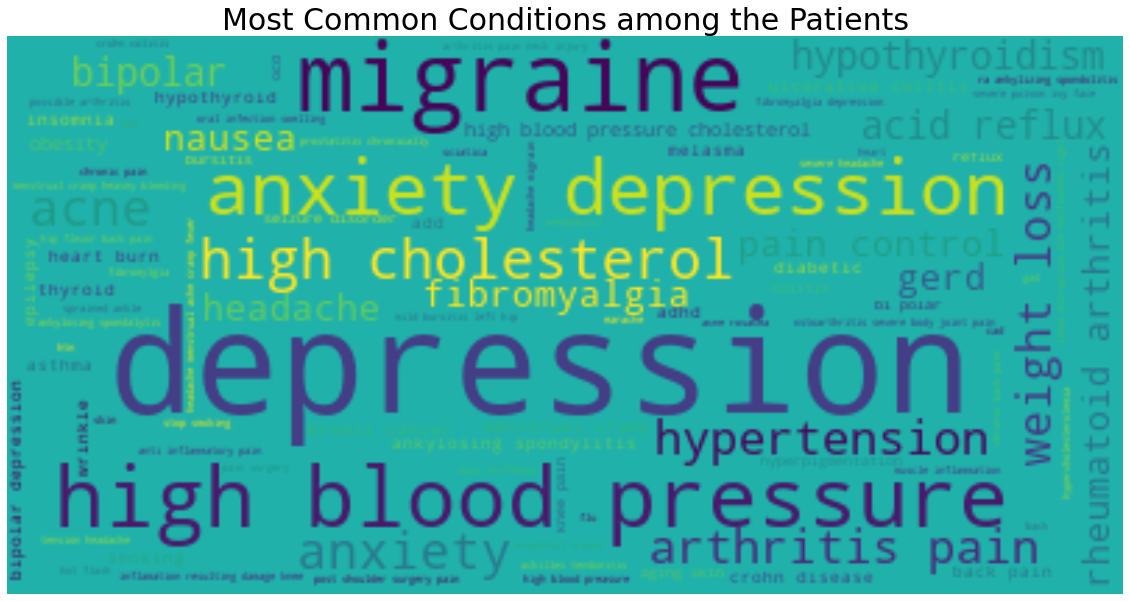

In [ ]:
Bigram_Freq = nltk.FreqDist(merged_df['Condition_Clean'])
bigram_wordcloud = WordCloud(background_color = 'lightseagreen', random_state = 21).generate_from_frequencies(Bigram_Freq)
plt.figure(figsize = (20,15))
plt.imshow(bigram_wordcloud,interpolation = 'bilinear')
plt.title('Most Common Conditions among the Patients', fontsize = 30)
plt.axis("off")
plt.show()

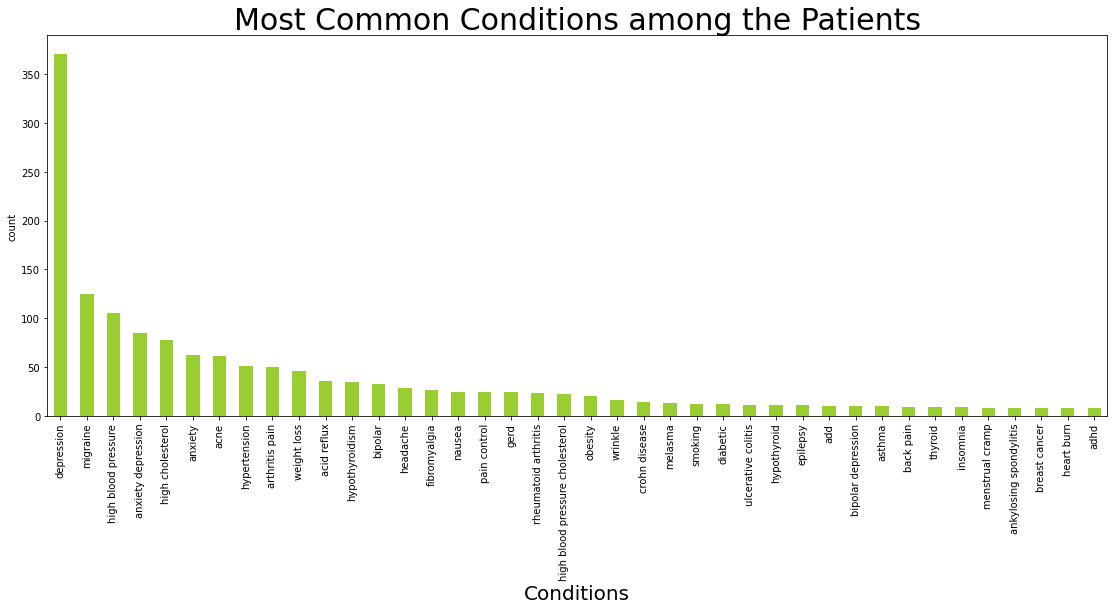

In [ ]:
# different types of conditions

merged_df['Condition_Clean'].value_counts()[:40].plot.bar(figsize = (19, 7), color = 'yellowgreen')
plt.title('Most Common Conditions among the Patients', fontsize = 30)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('count')
plt.show()

Text(0.5, 1.0, 'Most common words in Reviews')

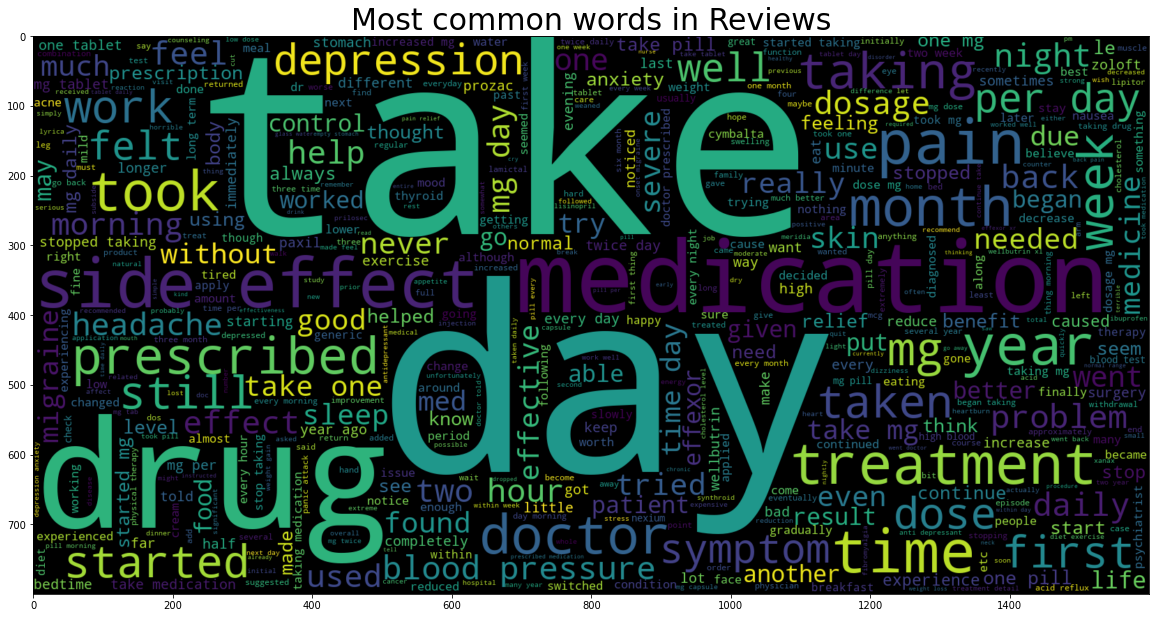

In [ ]:
plt.figure(figsize = (20,15))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(merged_df['Reviews_Clean']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Most common words in Reviews',fontsize=30)

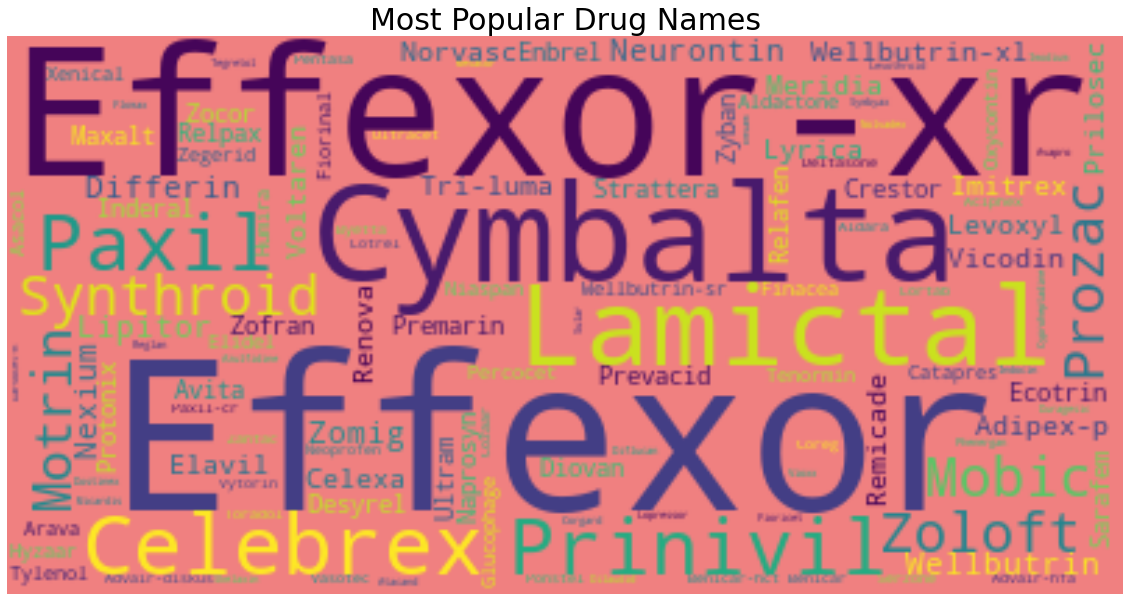

In [ ]:
Bigram_Freq = nltk.FreqDist(merged_df['Drug_Name'])
bigram_wordcloud = WordCloud(background_color = 'lightcoral', random_state = 21).generate_from_frequencies(Bigram_Freq)
plt.figure(figsize = (20, 15))
plt.imshow(bigram_wordcloud,interpolation = 'bilinear')
plt.title('Most Popular Drug Names', fontsize = 30)
plt.axis("off")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


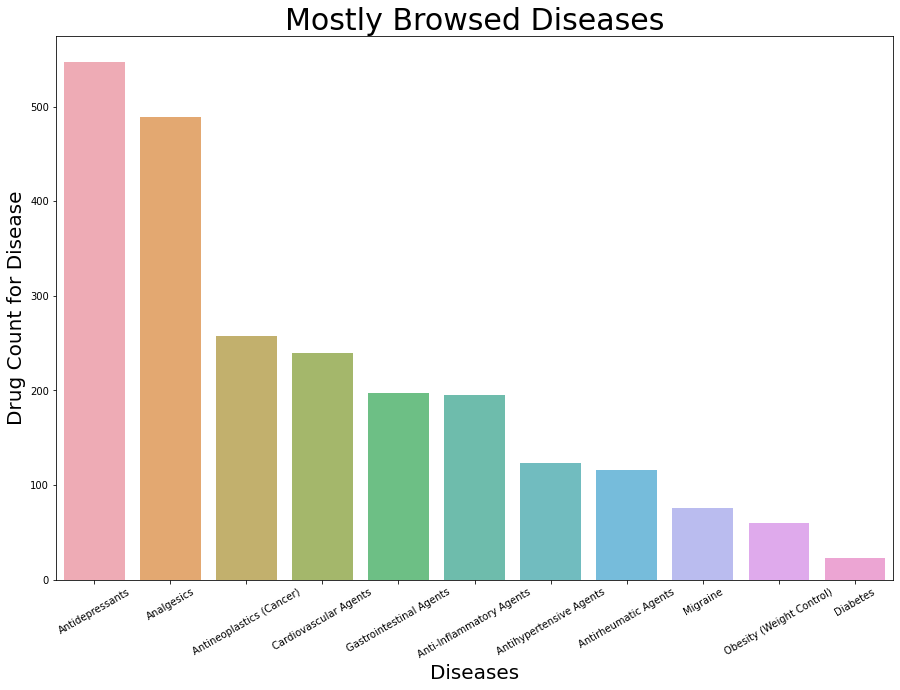

In [ ]:
%matplotlib inline
disease_count  = merged_df["Disease_Name"].value_counts()[:15,]
plt.figure(figsize=(15,10))
sns.barplot(disease_count.index, disease_count.values, alpha=0.8)
plt.title('Mostly Browsed Diseases', fontsize=30)
plt.ylabel('Drug Count for Disease', fontsize=20)
plt.xlabel('Diseases', fontsize=20)
plt.xticks(rotation=30)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


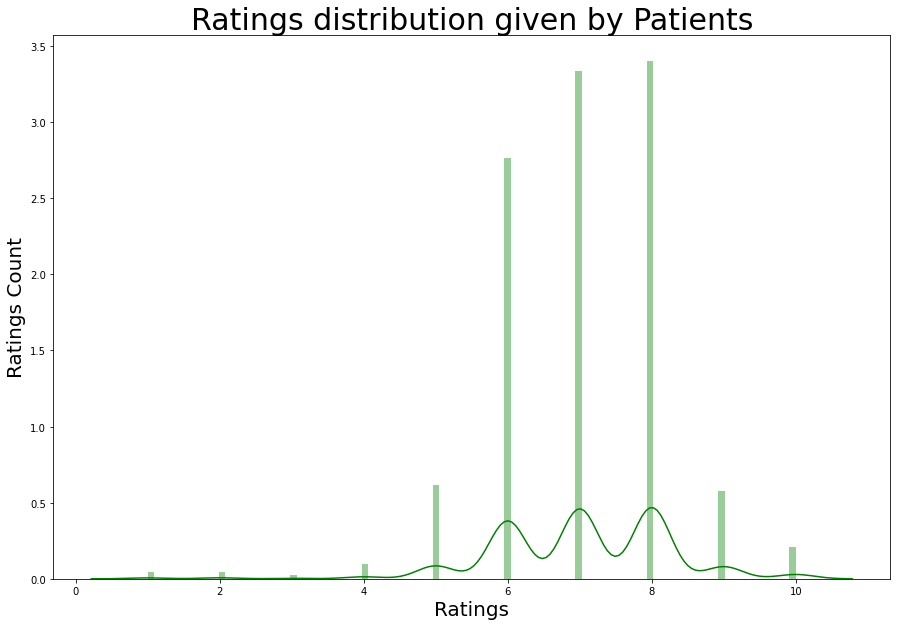

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(merged_df['Rating_Avg'], color='g', bins=100, hist_kws={'alpha': 0.4})
plt.title('Ratings distribution given by Patients', fontsize=30)
plt.ylabel('Ratings Count', fontsize=20)
plt.xlabel('Ratings', fontsize=20)
plt.show()

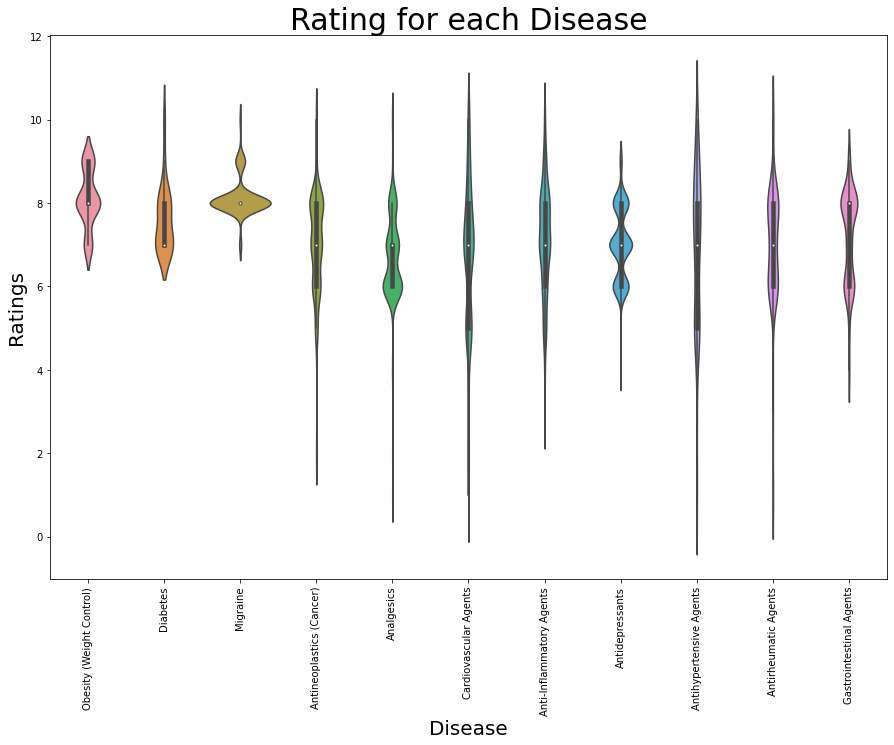

In [ ]:
plt.figure(figsize=(15,10))
data_exp = merged_df.explode('Rating_Avg')
sns.violinplot(data=data_exp, x='Disease_Name', y='Rating_Avg')
plt.title('Rating for each Disease', fontsize=30)
plt.ylabel('Ratings', fontsize=20)
plt.xlabel('Disease', fontsize=20)
plt.xticks(rotation=90)
plt.show()

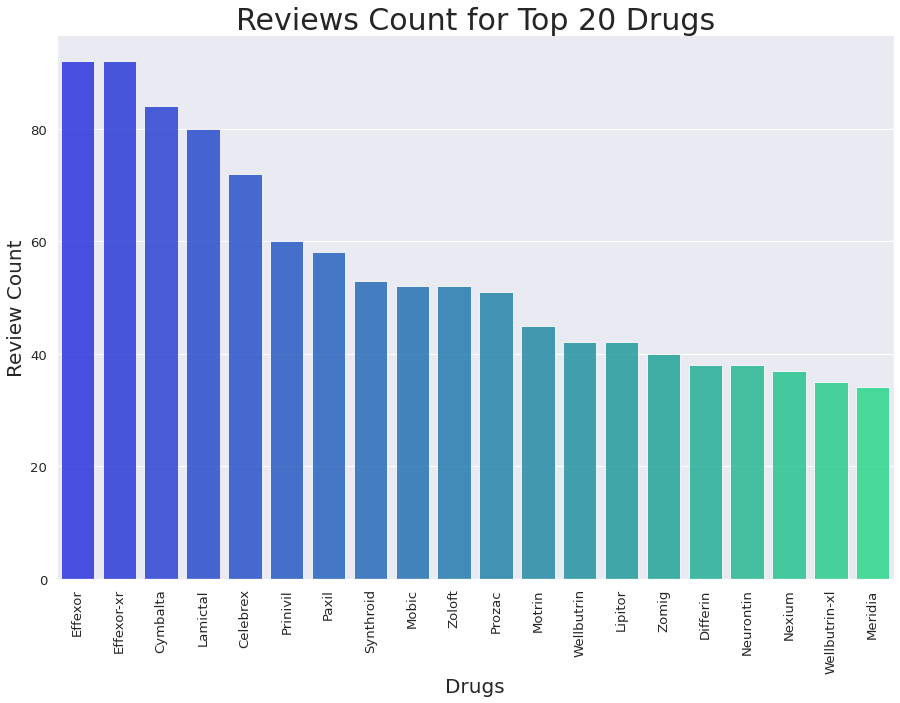

In [ ]:
%matplotlib inline
review_count  = merged_df["Drug_Name"].value_counts()[:20]
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.2, style = 'darkgrid')
sns_ = sns.barplot(x = review_count.index, y = review_count.values, palette = 'winter', alpha=0.8)
sns_.set_ylabel('Review Count', fontsize=20)
sns_.set_xlabel('Drugs', fontsize=20)
sns_.set_title("Reviews Count for Top 20 Drugs", fontsize=30)
plt.setp(sns_.get_xticklabels(), rotation = 90);

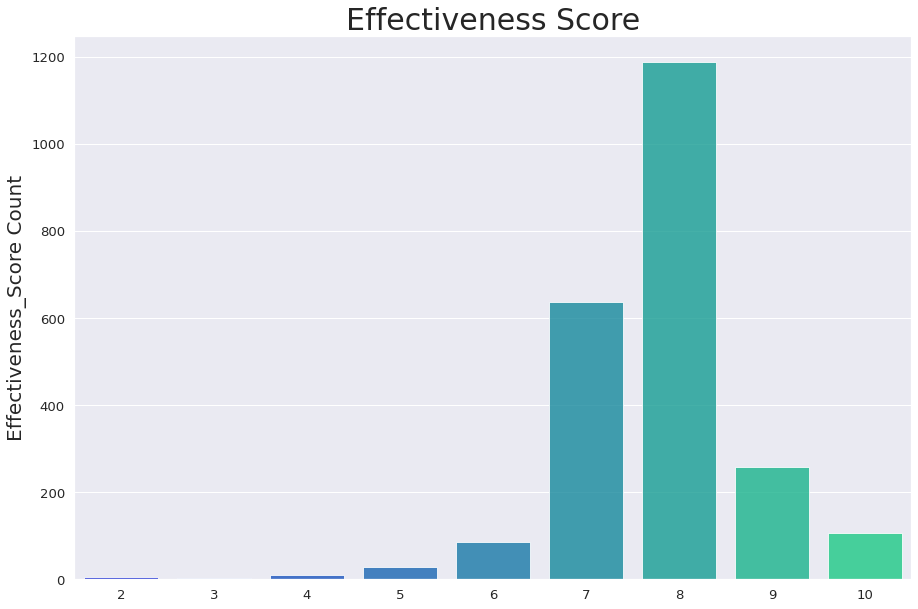

In [ ]:
Effectiveness_Score  = merged_df["Effectiveness_Score"].value_counts()[:25,]
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.2, style = 'darkgrid')
sns_ = sns.barplot(x = Effectiveness_Score.index, y = Effectiveness_Score.values, palette = 'winter', alpha=0.8)
sns_.set_ylabel('Effectiveness_Score Count', fontsize=20)
sns_.set_title("Effectiveness Score", fontsize=30)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


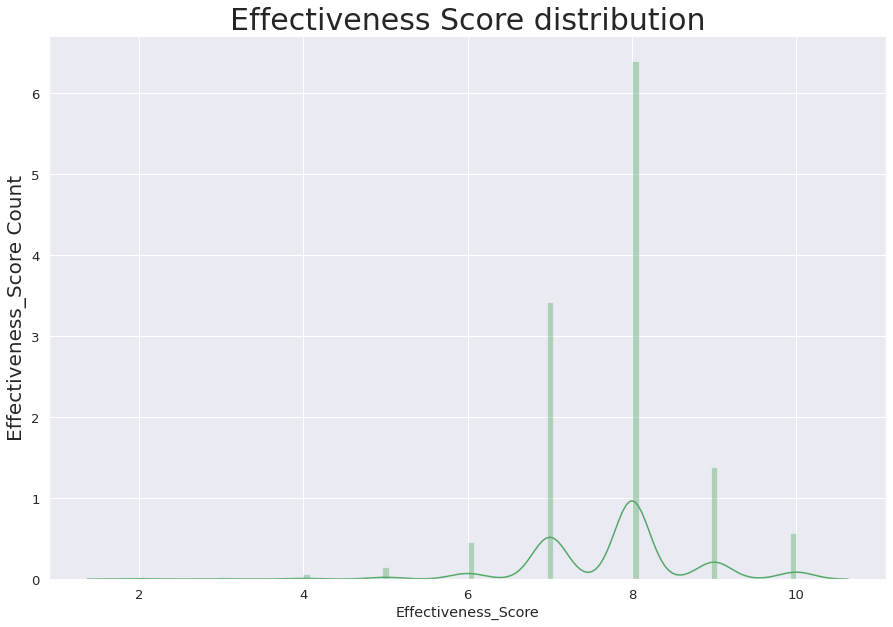

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(merged_df['Effectiveness_Score'], color='g', bins=100, hist_kws={'alpha': 0.4})
plt.title('Effectiveness Score distribution', fontsize=30)
plt.ylabel('Effectiveness_Score Count', fontsize=20)
plt.show()


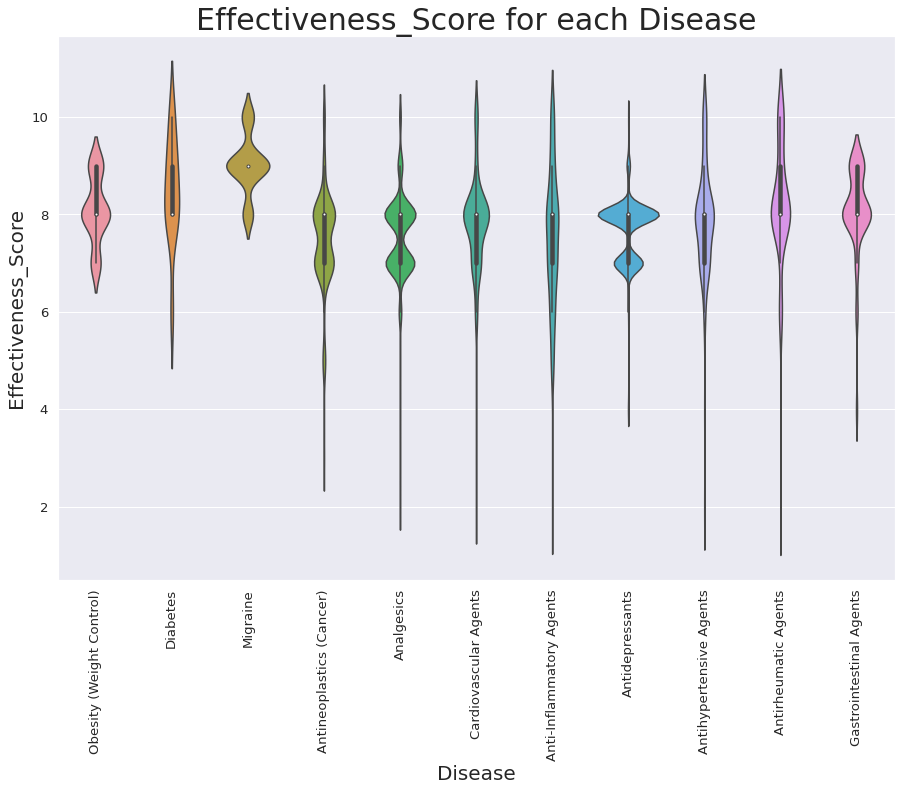

In [ ]:
plt.figure(figsize=(15,10))
effectiveness_score = merged_df.explode('Effectiveness_Score')
sns.violinplot(data=effectiveness_score, x='Disease_Name', y='Effectiveness_Score')
plt.title('Effectiveness_Score for each Disease', fontsize=30)
plt.ylabel('Effectiveness_Score', fontsize=20)
plt.xlabel('Disease', fontsize=20)
plt.xticks(rotation=90)
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


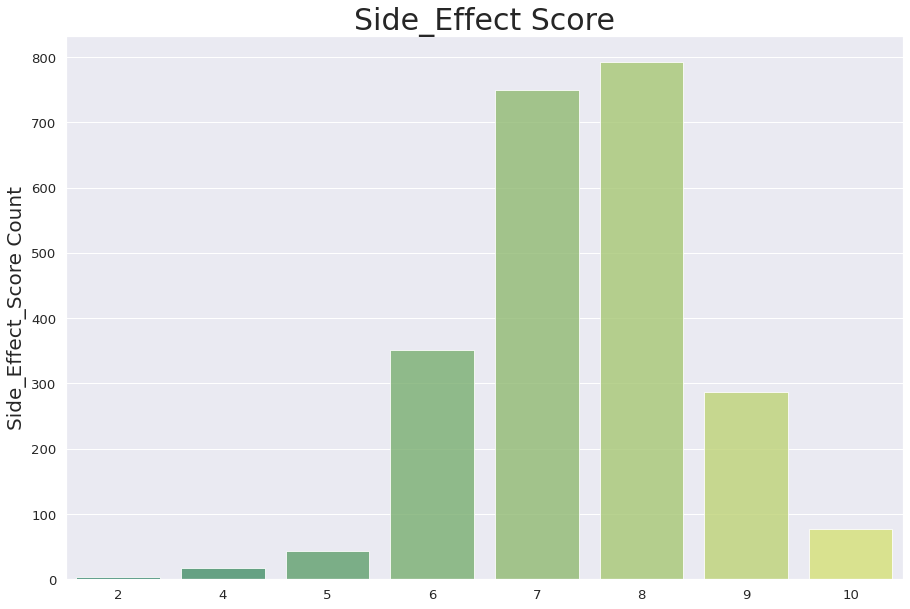

In [ ]:
side_effect_score  = merged_df["Side_Effect_Score"].value_counts()[:10,]
plt.figure(figsize=(15,10))
sns.barplot(side_effect_score.index, side_effect_score.values, alpha=0.8, palette = 'summer')
plt.title('Side_Effect Score', fontsize=30)
plt.ylabel('Side_Effect_Score Count', fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


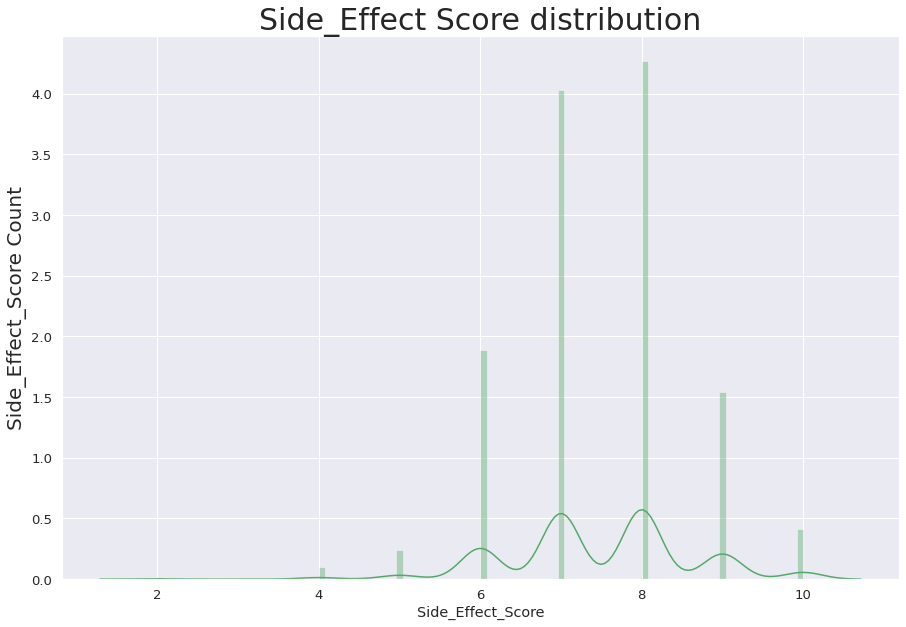

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(merged_df['Side_Effect_Score'], color='g', bins=100, hist_kws={'alpha': 0.4})
plt.title('Side_Effect Score distribution', fontsize=30)
plt.ylabel('Side_Effect_Score Count', fontsize=20)
plt.show()

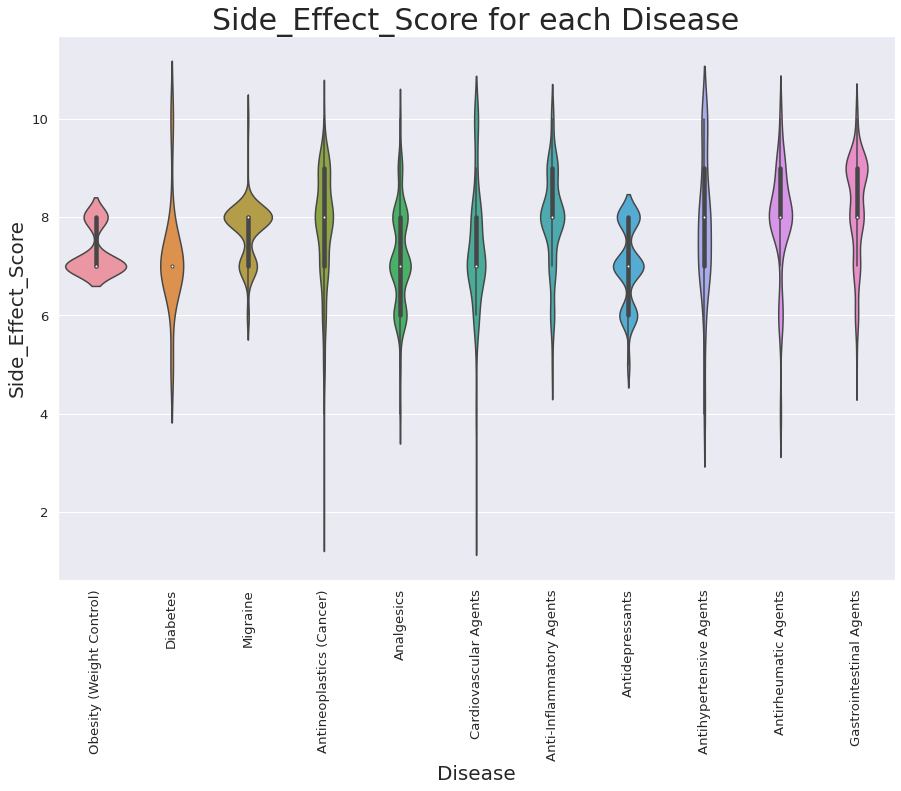

In [ ]:
plt.figure(figsize=(15,10))
side_effect_score = merged_df.explode('Side_Effect_Score')
sns.violinplot(data=side_effect_score, x='Disease_Name', y='Side_Effect_Score')
plt.title('Side_Effect_Score for each Disease', fontsize=30)
plt.ylabel('Side_Effect_Score', fontsize=20)
plt.xlabel('Disease', fontsize=20)
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Most common words in Benefits')

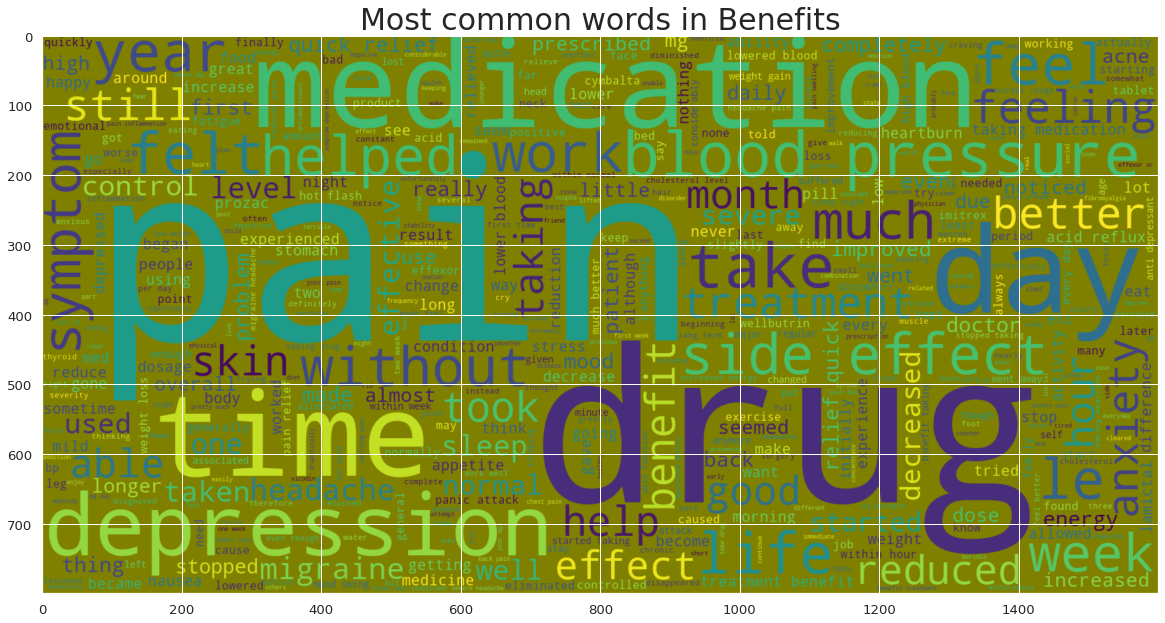

In [ ]:
plt.figure(figsize = (20,15))
wc = WordCloud(background_color = 'olive', max_words = 500 , width = 1600 , height = 800).generate(" ".join(merged_df['Benefits_Clean']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Most common words in Benefits',fontsize=30)

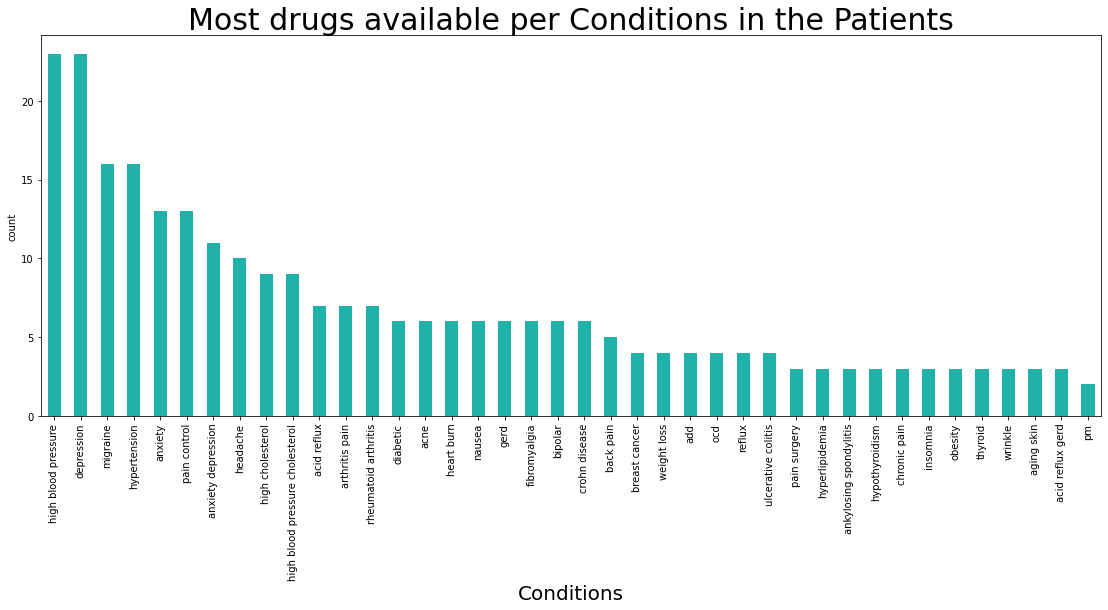

In [ ]:
# checking the most popular drugs per conditions

merged_df.groupby(['Condition_Clean'])['Drug_Name'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (19, 7), color = 'lightseagreen')
plt.title('Most drugs available per Conditions in the Patients', fontsize = 30)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('count')
plt.show()

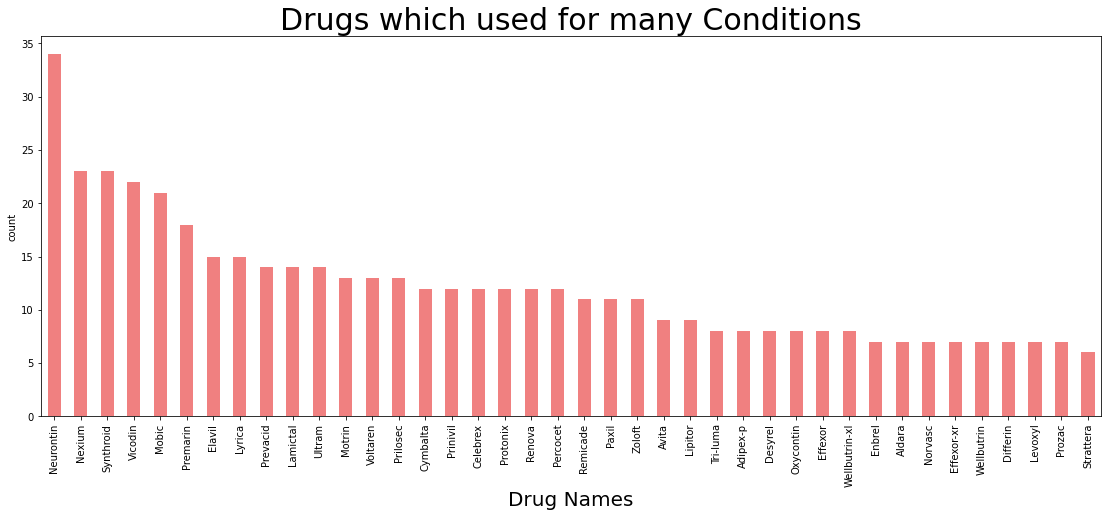

In [ ]:
# checking the most popular drugs per conditions

merged_df.groupby(['Drug_Name'])['Condition_Clean'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (19, 7), color = 'lightcoral')
plt.title('Drugs which used for many Conditions', fontsize = 30)
plt.xlabel('Drug Names', fontsize = 20)
plt.ylabel('count')
plt.show()

In [ ]:
rating_count = merged_df['Rating_Avg'].value_counts().values[:8]

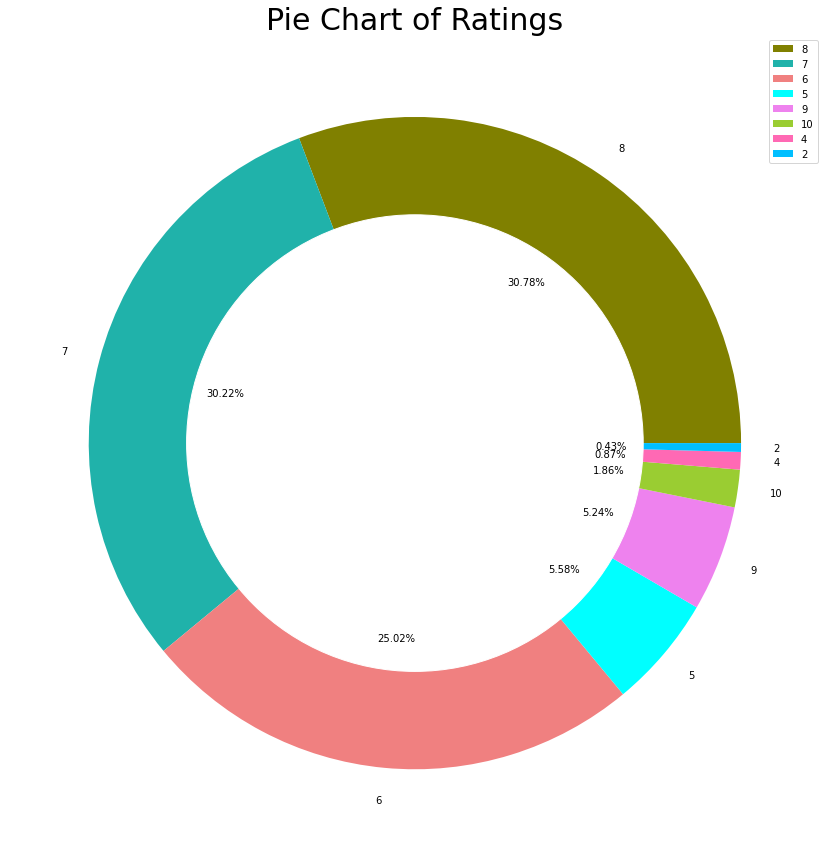

In [ ]:
size = rating_count[0], rating_count[1], rating_count[2], rating_count[3], rating_count[4], rating_count[5], rating_count[6], rating_count[7]
colors = ['olive', 'lightseagreen', 'lightcoral', 'aqua', 'violet', 'yellowgreen', 'hotpink', 'deepskyblue']
labels = "8", "7", "6", "5", "9", "10", "4", "2"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')
plt.rcParams['figure.figsize'] = (15,15)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart of Ratings', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

# **Sentiment Analysis and Modeling:**

In [ ]:
# calculate sentiment_score using reviews:
pos=neg=obj=count=0
postagging = []

for review in merged_df['Reviews_Clean']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

merged_df['pos_tags'] = postagging


def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []
    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]
    pos=neg=obj=count=0


senti_score = []
for pos_val in merged_df['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0


merged_df['senti_score'] = senti_score
print(merged_df.head(5))

  Drug_Name              Disease_Name  Review_Count  Rating_Avg  Rating  \
0  Adipex-p  Obesity (Weight Control)            32           8       5   
1  Adipex-p  Obesity (Weight Control)            32           8      10   
2  Adipex-p  Obesity (Weight Control)            32           8       6   
3  Adipex-p  Obesity (Weight Control)            32           8      10   
4  Adipex-p  Obesity (Weight Control)            32           8       3   

   Effectiveness_Score  Side_Effect_Score           Effectiveness  \
0                    8                  7  considerably effective   
1                    8                  7        highly effective   
2                    8                  7    moderately effective   
3                    8                  7        highly effective   
4                    8                  7    marginally effective   

                    Side_Effects    Condition  \
0  extremely severe side effects  lose weight   
1              mild side effects  we

In [ ]:
overall = ["Positive" if i >= 0.05 else "Negative" if i <= -0.05 else "Neutral" for i in merged_df['senti_score']]
merged_df['Review_Sentiment']=overall

In [ ]:
merged_df[['Drug_Name', 'Rating', 'Reviews_Clean', 'senti_score', 'Review_Sentiment']].head(10)

Drug_Name  Rating                                      Reviews_Clean  \
0  Adipex-p       5              prescribe take one every morning food   
1  Adipex-p      10  given drug help lose weight worked perfect cos...   
2  Adipex-p       6  took medication month time week prevent addict...   
3  Adipex-p      10  low calorie diet exercise three time week one ...   
4  Adipex-p       3                                                      
5  Adipex-p       9  taking good job decreasing appetite stopped ap...   
6  Adipex-p      10  take pill morning treat add like symptom start...   
7  Adipex-p      10  take pill morning treat add like symptom start...   
8  Adipex-p       5  lb overweight eating time mostly pm always cra...   
9  Adipex-p       9  first fill patient questionaire submit blood b...   

   senti_score Review_Sentiment  
0        0.000          Neutral  
1        1.000         Positive  
2       -0.375         Negative  
3       -0.125         Negative  
4        0.000          Neutral  
5        0.500         Positive  
6       -2.500         Negative  
7       -2.500         Negative  
8       -0.625         Negative  
9        0.500         Positive

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


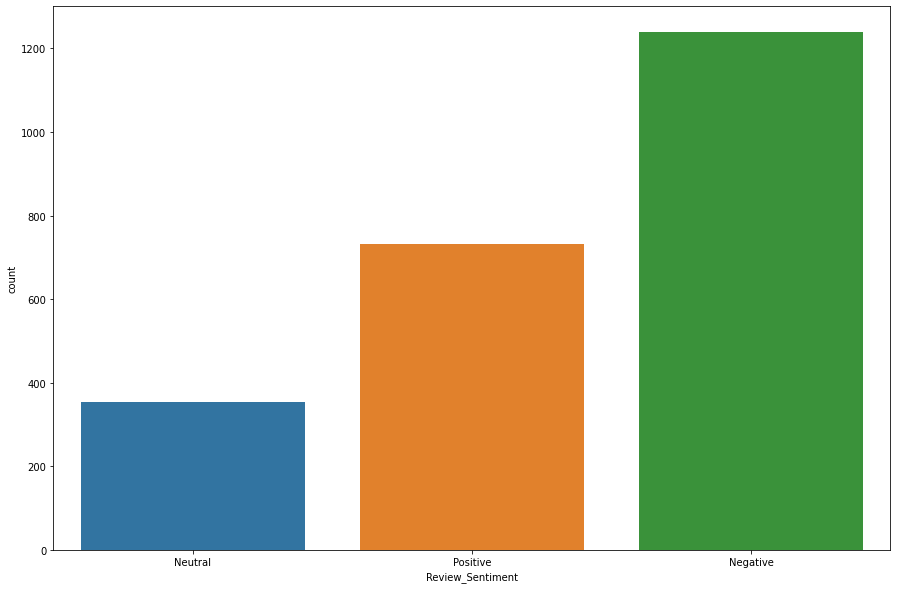

In [ ]:
plt.figure(figsize = (15,10))
sns.countplot(merged_df['Review_Sentiment'])

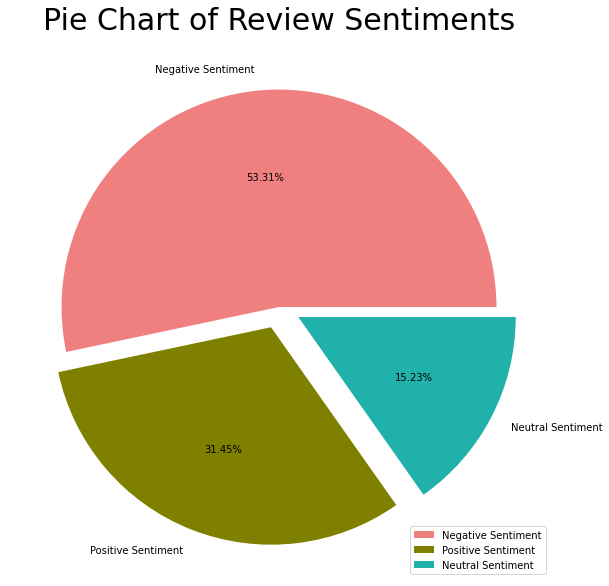

In [ ]:
# a pie chart of Review Sentiments of the patients
overall_sentiment = merged_df['Review_Sentiment'].value_counts().values

size = overall_sentiment[0], overall_sentiment[1], overall_sentiment[2]
colors = ['lightcoral', 'olive', 'lightseagreen']
labels = "Negative Sentiment", "Positive Sentiment", "Neutral Sentiment"
explode = [0, 0.1, 0.1]
plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart of Review Sentiments', fontsize = 30)
plt.legend()
plt.show()

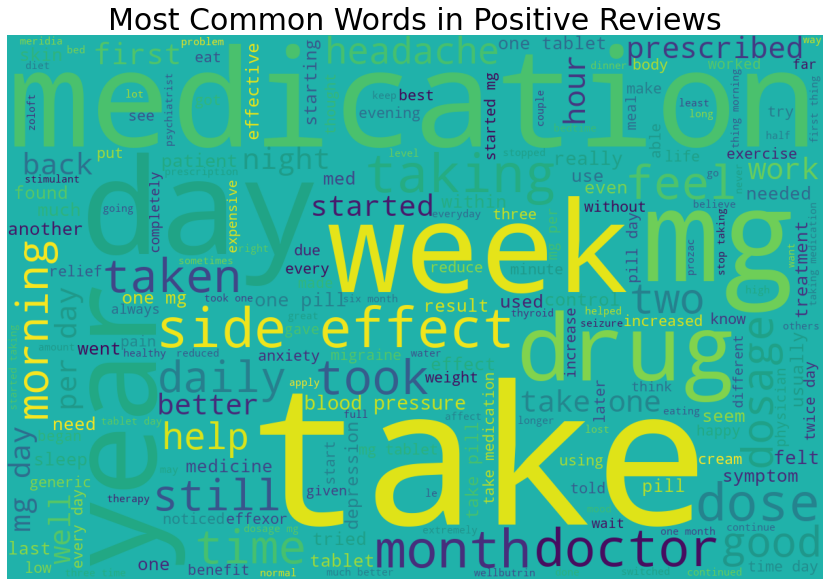

In [ ]:
# Word Cloud for the positive sentiments

positive_sentiments = " ".join([text for text in merged_df['Reviews_Clean'][merged_df['Review_Sentiment'] == "Positive"]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightseagreen', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)
plt.rcParams['figure.figsize'] = (15, 10)
plt.title('Most Common Words in Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


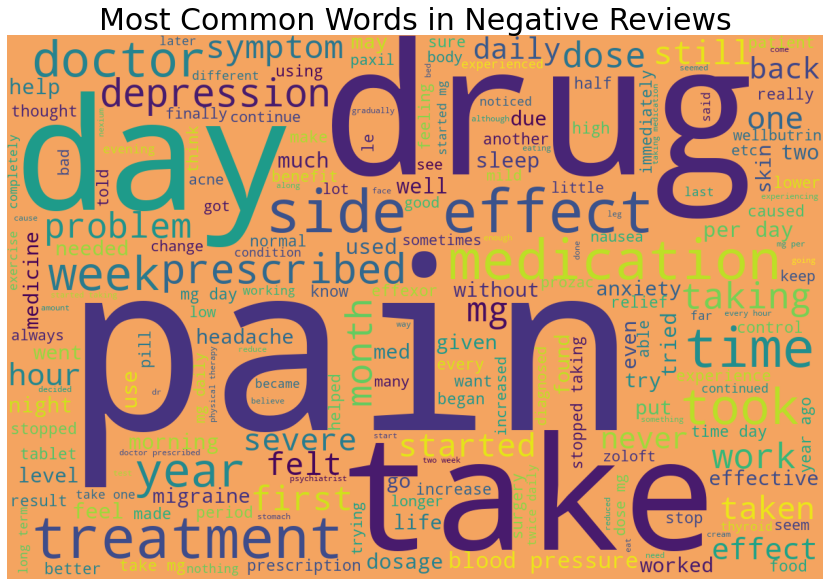

In [ ]:
# Word Cloud for the Negative sentiments

negative_sentiments = " ".join([text for text in merged_df['Reviews_Clean'][merged_df['Review_Sentiment'] == "Negative"]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'sandybrown', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)
plt.rcParams['figure.figsize'] = (15, 10)
plt.title('Most Common Words in Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

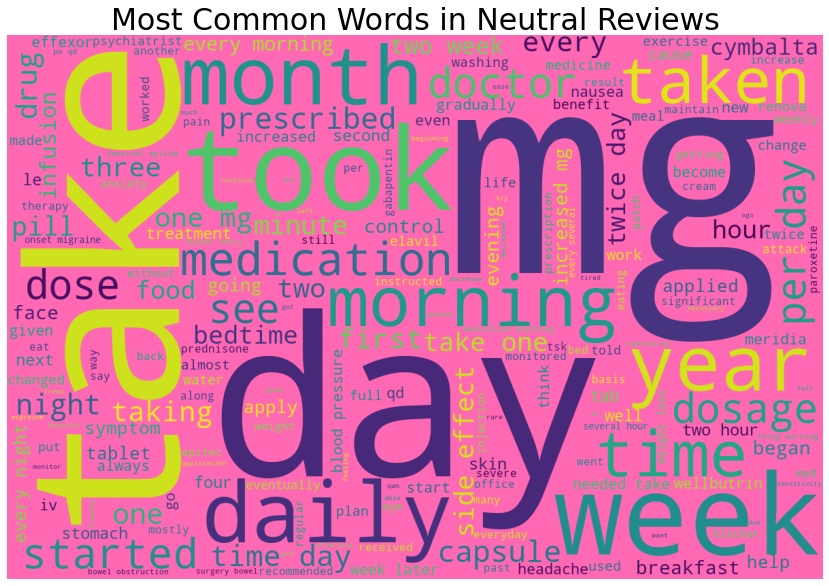

In [ ]:
# Word Cloud for the Neutral sentiments

neutral_sentiments = " ".join([text for text in merged_df['Reviews_Clean'][merged_df['Review_Sentiment'] == "Neutral"]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'hotpink', stopwords = stopwords, width = 1200, height = 800).generate(neutral_sentiments)
plt.rcParams['figure.figsize'] = (15, 10)
plt.title('Most Common Words in Neutral Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

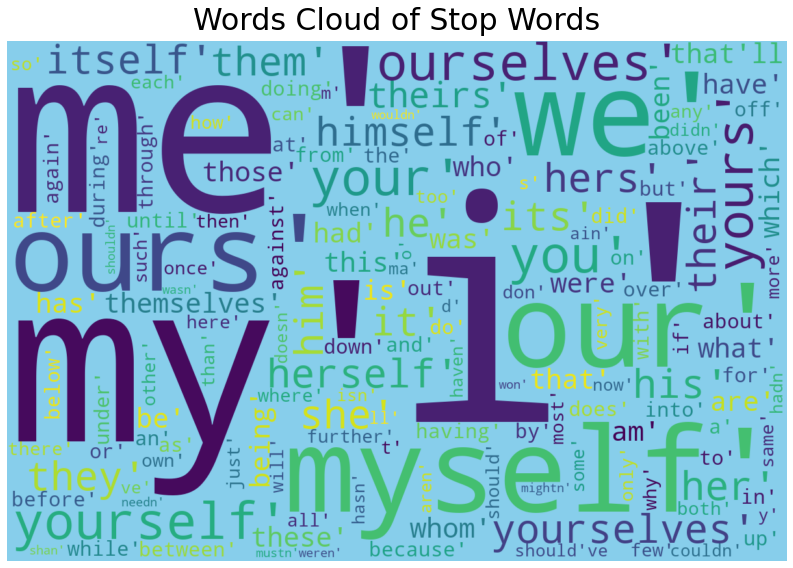

In [ ]:
def stopwords_wordcloud(text, title = None):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)
    wordcloud = WordCloud(background_color='skyblue',
                    stopwords = stopwords,
                    max_words = 200,
                    random_state = 42,
                    width = 1200,
                    height = 800,)
    wordcloud.generate(str(text))
    plt.rcParams['figure.figsize'] = (15, 8)
    plt.imshow(wordcloud, interpolation="bilinear");
    plt.title(title, fontdict={'size': 30, 'color': 'black',
                              'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

stopwords_wordcloud(stops, title="Words Cloud of Stop Words")

## **Modeling:**

In [ ]:
new_df = merged_df[merged_df['Review_Count']!=1]

In [ ]:
# creating features:

X_feat=new_df['Reviews_Clean']
y=new_df['Drug_Name']

In [ ]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# TF_IDF Vectorization

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

accuracy:   0.371
Confusion matrix, without normalization


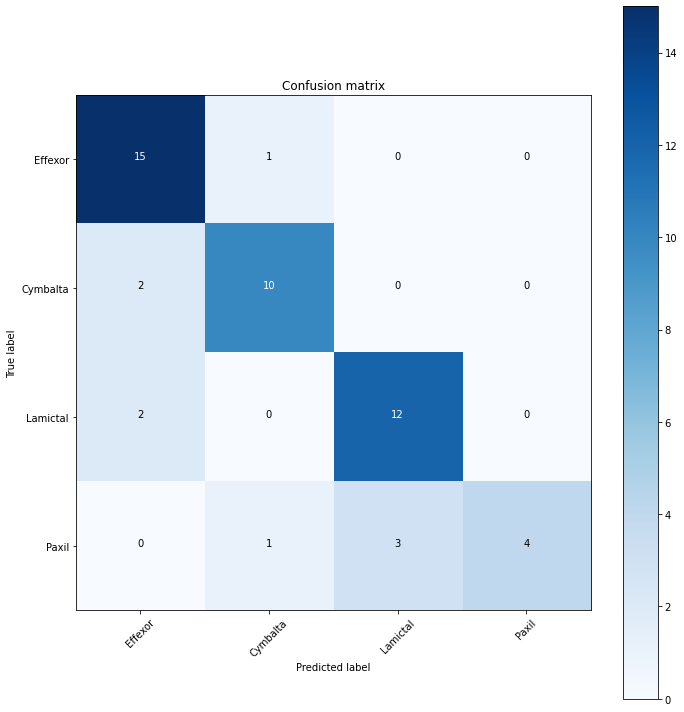

In [ ]:
# TF_IDF 1-Gram: LogisticRegression
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_LR = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_LR = tfidf_vectorizer.transform(X_test)

pass_tf = LogisticRegression()
pass_tf.fit(tfidf_train_LR, y_train)
pred = pass_tf.predict(tfidf_test_LR)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Effexor', 'Cymbalta','Lamictal','Paxil'])
plot_confusion_matrix(cm, classes=['Effexor', 'Cymbalta','Lamictal','Paxil'])

accuracy:   0.557
Confusion matrix, without normalization


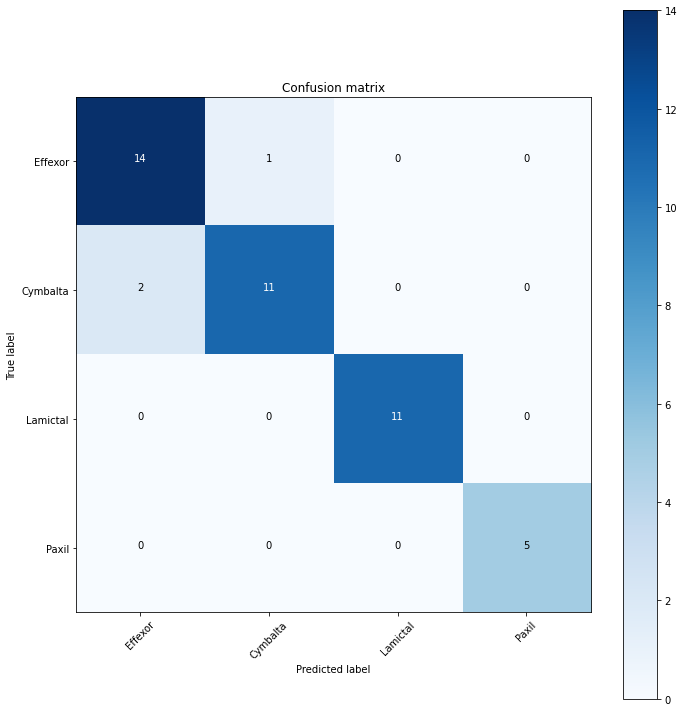

In [ ]:
# TF_IDF 1-Gram: Passive Aggressive Classifier
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_PAC = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_PAC = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_PAC, y_train)
pred = pass_tf.predict(tfidf_test_PAC)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Effexor', 'Cymbalta','Lamictal','Paxil'])
plot_confusion_matrix(cm, classes=['Effexor', 'Cymbalta','Lamictal','Paxil'])

accuracy:   0.526
Confusion matrix, without normalization


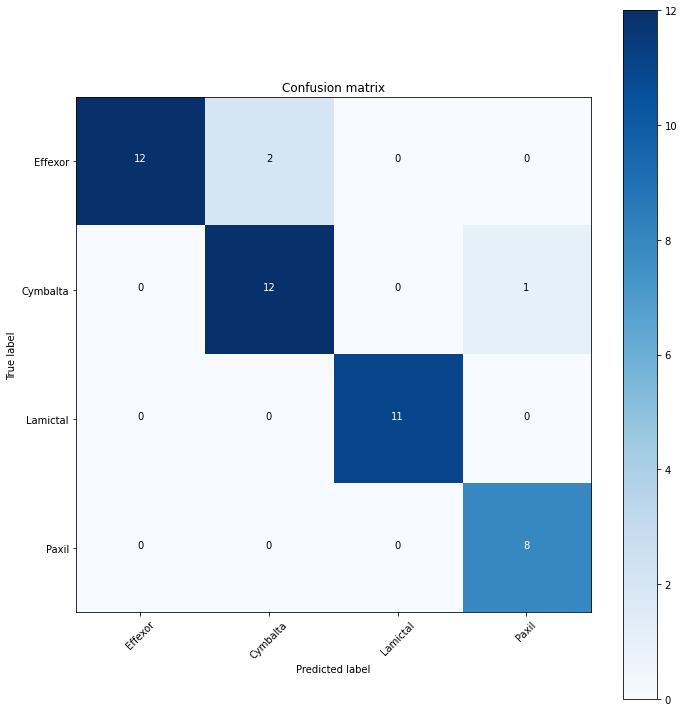

In [ ]:
# TF_IDF 1-Gram: XGBClassifier

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_XGB = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_XGB = tfidf_vectorizer.transform(X_test)

pass_tf = XGBClassifier()
pass_tf.fit(tfidf_train_XGB, y_train)
pred = pass_tf.predict(tfidf_test_XGB)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Effexor', 'Cymbalta','Lamictal','Paxil'])
plot_confusion_matrix(cm, classes=['Effexor', 'Cymbalta','Lamictal','Paxil'])

accuracy:   0.497
Confusion matrix, without normalization


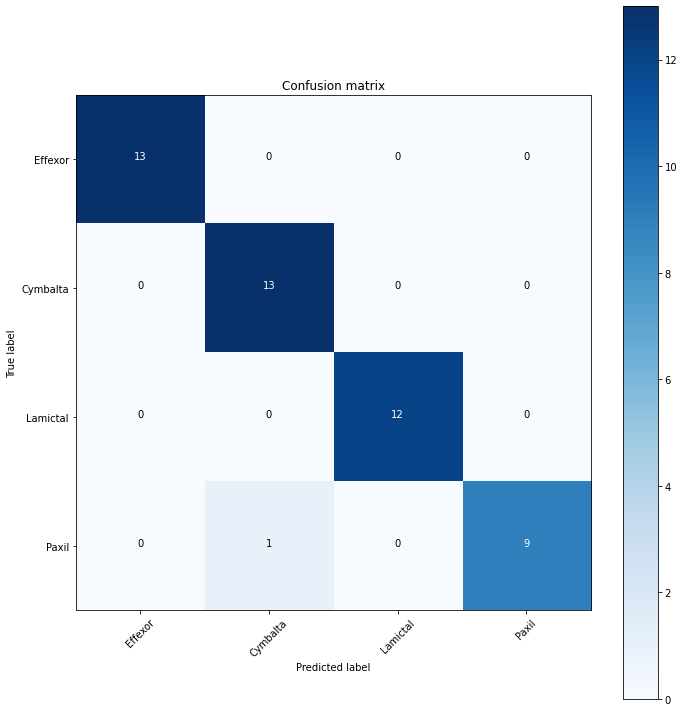

In [ ]:
# TF_IDF 1-Gram: LGBMClassifier

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_LGBM = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_LGBM = tfidf_vectorizer.transform(X_test)

pass_tf = LGBMClassifier()
pass_tf.fit(tfidf_train_LGBM, y_train)
pred = pass_tf.predict(tfidf_test_LGBM)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Effexor', 'Cymbalta','Lamictal','Paxil'])
plot_confusion_matrix(cm, classes=['Effexor', 'Cymbalta','Lamictal','Paxil'])

accuracy:   0.494
Confusion matrix, without normalization


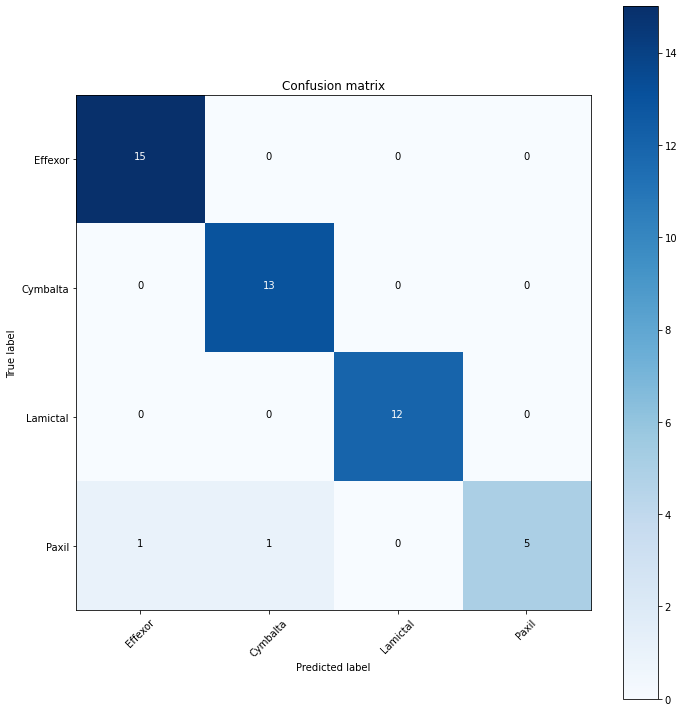

In [ ]:
# TF_IDF Bigram: LGBMClassifier
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_LGBM2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_LGBM2 = tfidf_vectorizer2.transform(X_test)

pass_tf = LGBMClassifier()
pass_tf.fit(tfidf_train_LGBM2, y_train)
pred = pass_tf.predict(tfidf_test_LGBM2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Effexor', 'Cymbalta','Lamictal','Paxil'])
plot_confusion_matrix(cm, classes=['Effexor', 'Cymbalta','Lamictal','Paxil'])

accuracy:   0.494
Confusion matrix, without normalization


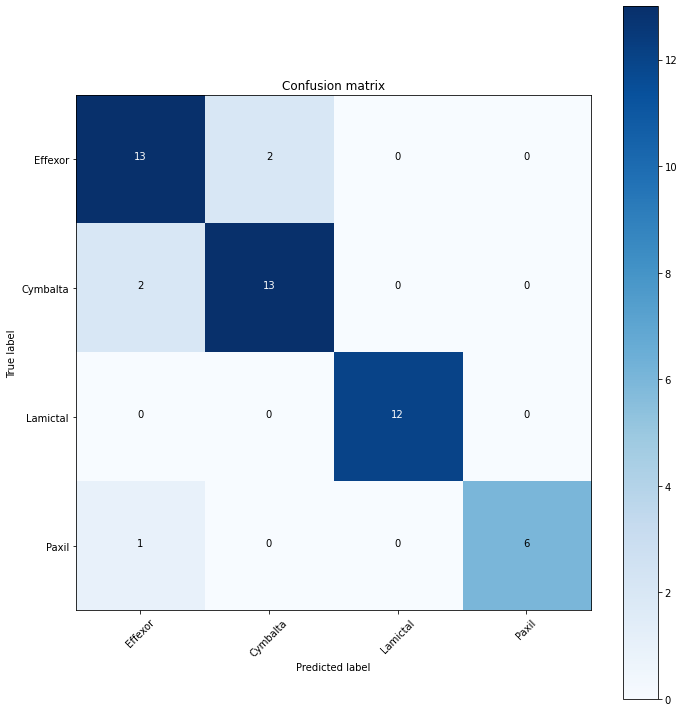

In [ ]:
# IF_IDF TRIGRAM: LGBMClassifier
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_LGBM3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_LGBM3 = tfidf_vectorizer3.transform(X_test)

pass_tf = LGBMClassifier()
pass_tf.fit(tfidf_train_LGBM3, y_train)
pred = pass_tf.predict(tfidf_test_LGBM3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Effexor', 'Cymbalta','Lamictal','Paxil'])
plot_confusion_matrix(cm, classes=['Effexor', 'Cymbalta','Lamictal','Paxil'])

accuracy:   0.564
Confusion matrix, without normalization


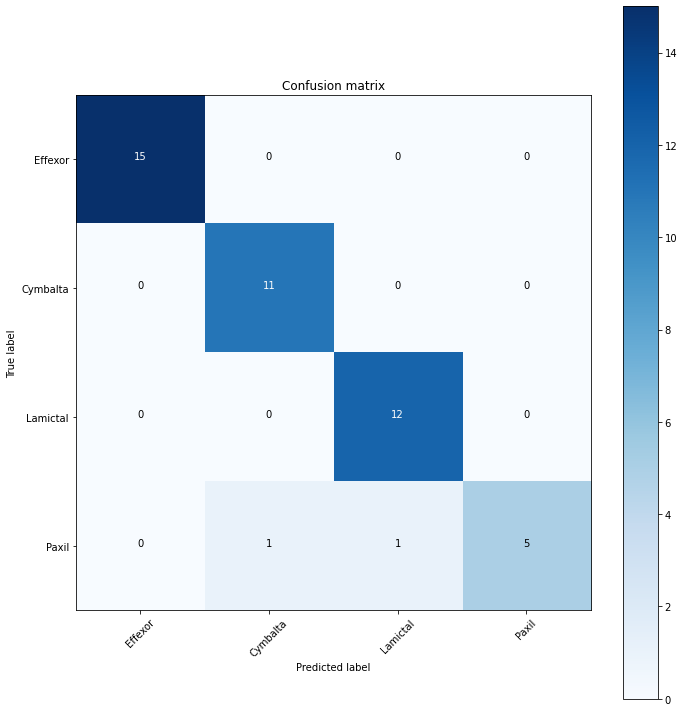

In [ ]:
# TFIDF BIGRAM: Passive Aggressive Classifier
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_PAC2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_PAC2 = tfidf_vectorizer2.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_PAC2, y_train)
pred = pass_tf.predict(tfidf_test_PAC2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Effexor', 'Cymbalta','Lamictal','Paxil'])
plot_confusion_matrix(cm, classes=['Effexor', 'Cymbalta','Lamictal','Paxil'])

accuracy:   0.575
Confusion matrix, without normalization


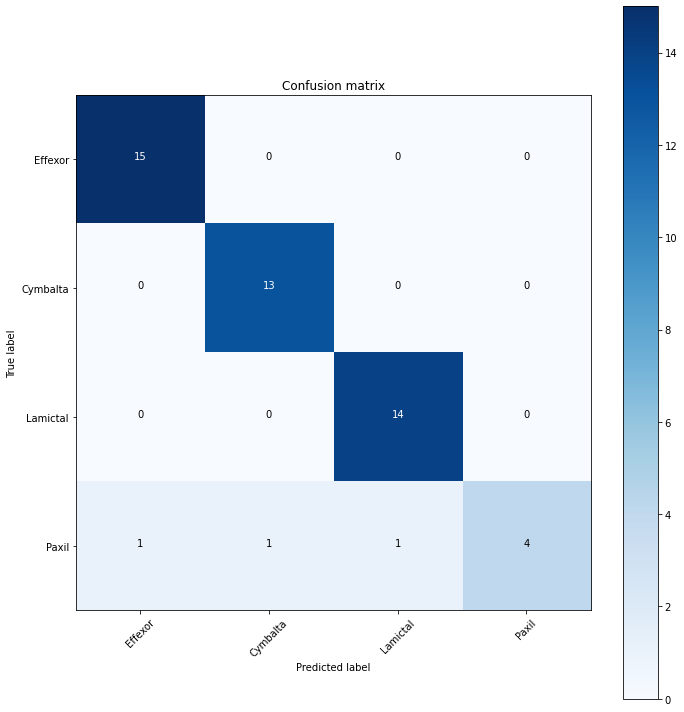

In [ ]:
# TFIDF TRIGRAM: Passive Aggressive Classifier
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_PAC3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_PAC3 = tfidf_vectorizer3.transform(X_test)

pass_tf_pac = PassiveAggressiveClassifier()
pass_tf_pac.fit(tfidf_train_PAC3, y_train)
pred = pass_tf_pac.predict(tfidf_test_PAC3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Effexor', 'Cymbalta','Lamictal','Paxil'])
plot_confusion_matrix(cm, classes=['Effexor', 'Cymbalta','Lamictal','Paxil'])

**Conclusion: Passive Aggressive Classifier Model's Accuracy is better than other models.**

In [ ]:
text1 =["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test1 = tfidf_vectorizer3.transform(text1)
pred1=pass_tf_pac.predict(test1)[0]
pred1

'Synthroid'

In [ ]:
text2 =["i took the celebrex once a day for a month and am now doing pt for the achilles tendonitis.   the only reason for stopping the drug was out of concern for long term side effects (kidney eg)."]
test2 = tfidf_vectorizer3.transform(text2)
pred2=pass_tf_pac.predict(test2)[0]
pred2


'Celebrex'

## **Recommend Drug based on Review Sentiment:**

In [ ]:
positive_df = new_df[new_df['Review_Sentiment'] == "Positive"]

In [ ]:
recommend_drugs = positive_df.groupby(['Condition_Clean','Drug_Name']).agg({'senti_score' : ['mean','count']})


In [ ]:
recommend_drugs.shape

(287, 2)

In [ ]:
recommend_drugs.head(287)

senti_score  \
                                                                       mean   
Condition_Clean                                  Drug_Name                    
acid reflux                                      Aciphex           0.375000   
                                                 Nexium            0.375000   
                                                 Prevacid          0.125000   
                                                 Protonix          0.125000   
                                                 Zegerid           1.250000   
acid reflux barrett esophagus                    Nexium            0.125000   
acid reflux gerd                                 Zegerid           0.500000   
acl surgery                                      Percocet          0.125000   
acne                                             Aldactone         0.562500   
                                                 Avita             0.125000   
                                                 Differin          0.421875   
                                                 Finacea           0.375000   
                                                 Renova            0.625000   
acne rosacea                                     Finacea           0.250000   
active thyroid                                   Levoxyl           0.125000   
                                                 Synthroid         0.875000   
add                                              Strattera         3.166667   
adhd                                             Strattera         0.312500   
                                                 Wellbutrin-sr     0.250000   
adhd predominantly inattentive                   Strattera         3.625000   
adult add                                        Strattera         3.250000   
aging skin                                       Avita             1.375000   
                                                 Renova            0.437500   
allergy                                          Cyproheptadine    0.125000   
allergy runny nose hay fever                     Cyproheptadine    0.500000   
ankylosing spondylitis                           Enbrel            0.375000   
                                                 Humira            0.125000   
anxiety                                          Cymbalta          3.375000   
                                                 Effexor           1.875000   
                                                 Effexor-xr        0.250000   
                                                 Paxil             0.458333   
                                                 Paxil-cr          0.625000   
                                                 Wellbutrin        0.250000   
                                                 Zoloft            0.416667   
anxiety depression                               Celexa            0.750000   
                                                 Cymbalta          0.125000   
                                                 Effexor           0.125000   
                                                 Effexor-xr        0.458333   
                                                 Lamictal          0.250000   
                                                 Paxil             0.500000   
                                                 Wellbutrin        0.687500   
                                                 Wellbutrin-xl     0.125000   
                                                 Zoloft            0.625000   
appetite suppression                             Adipex-p          0.500000   
arthritis knee                                   Voltaren          2.500000   
arthritis knee pain                              Mobic             1.375000   
arthritis pain                                   Arava             0.125000   
                                                 Celebrex          0.687500   
                                   